# Import Cleaned Data & Packages

In [224]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

In [225]:
#See part 1 for scrubbing process

df  = pd.read_csv('cleaned_df')
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,yr_sold,home_age,yrs_since_reno,neighborhood
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0,1340,5650,2014,65,2020,Seattle
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400,1690,7639,2014,69,29,Seattle
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0,2720,8062,2015,87,2020,Kenmore
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910,1360,5000,2014,55,2020,Seattle
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0,1800,7503,2015,33,2020,Sammamish


# Bucketing data

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21188 entries, 0 to 21187
Data columns (total 18 columns):
price             21188 non-null float64
bedrooms          21188 non-null int64
bathrooms         21188 non-null float64
sqft_living       21188 non-null int64
sqft_lot          21188 non-null int64
floors            21188 non-null float64
waterfront        21188 non-null float64
view              21188 non-null float64
condition         21188 non-null int64
grade             21188 non-null int64
sqft_above        21188 non-null int64
sqft_basement     21188 non-null int64
sqft_living15     21188 non-null int64
sqft_lot15        21188 non-null int64
yr_sold           21188 non-null int64
home_age          21188 non-null int64
yrs_since_reno    21188 non-null int64
neighborhood      21188 non-null object
dtypes: float64(5), int64(12), object(1)
memory usage: 2.9+ MB


In [227]:
#Adding a new column to replace the sqft_basement
#sqft_basement data is very skewed since any house w/o a basement was assigned 0 
#(see part 2)

df.loc[df['sqft_basement'] == 0, 'has_basement'] = 0
df.loc[df['sqft_basement'] != 0, 'has_basement'] = 1

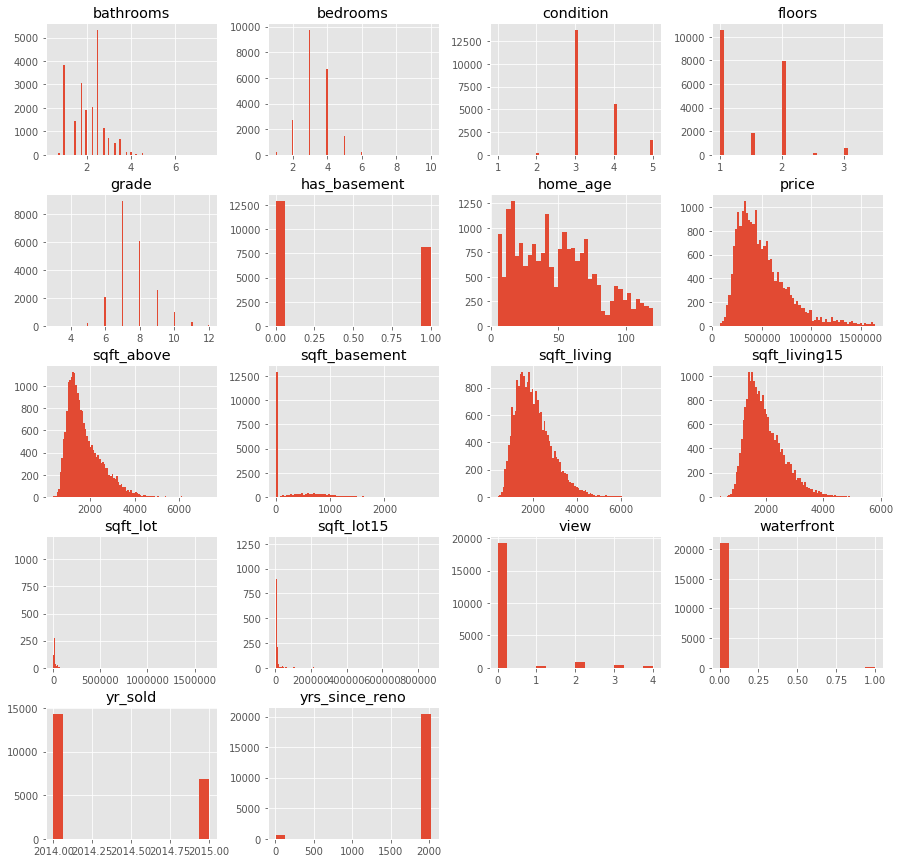

In [228]:
df.hist(bins = 'auto', figsize = (15,15));

In [229]:
#splitting continous and categorical variables
#Dropping sqft_basement

#Categorical df 

df_cat = df[['yrs_since_reno','waterfront','view','condition','grade','has_basement','neighborhood',
            'yr_sold']].copy()

#Numerical df

df_num = df[['bathrooms','bedrooms','floors','home_age','price','sqft_above','sqft_living','sqft_living15',
            'sqft_lot','sqft_lot15',]].copy()


In [230]:
len(df_num.columns)

10

# Removing outliers in df_num

In [231]:
#scatter plots to visualize outliers

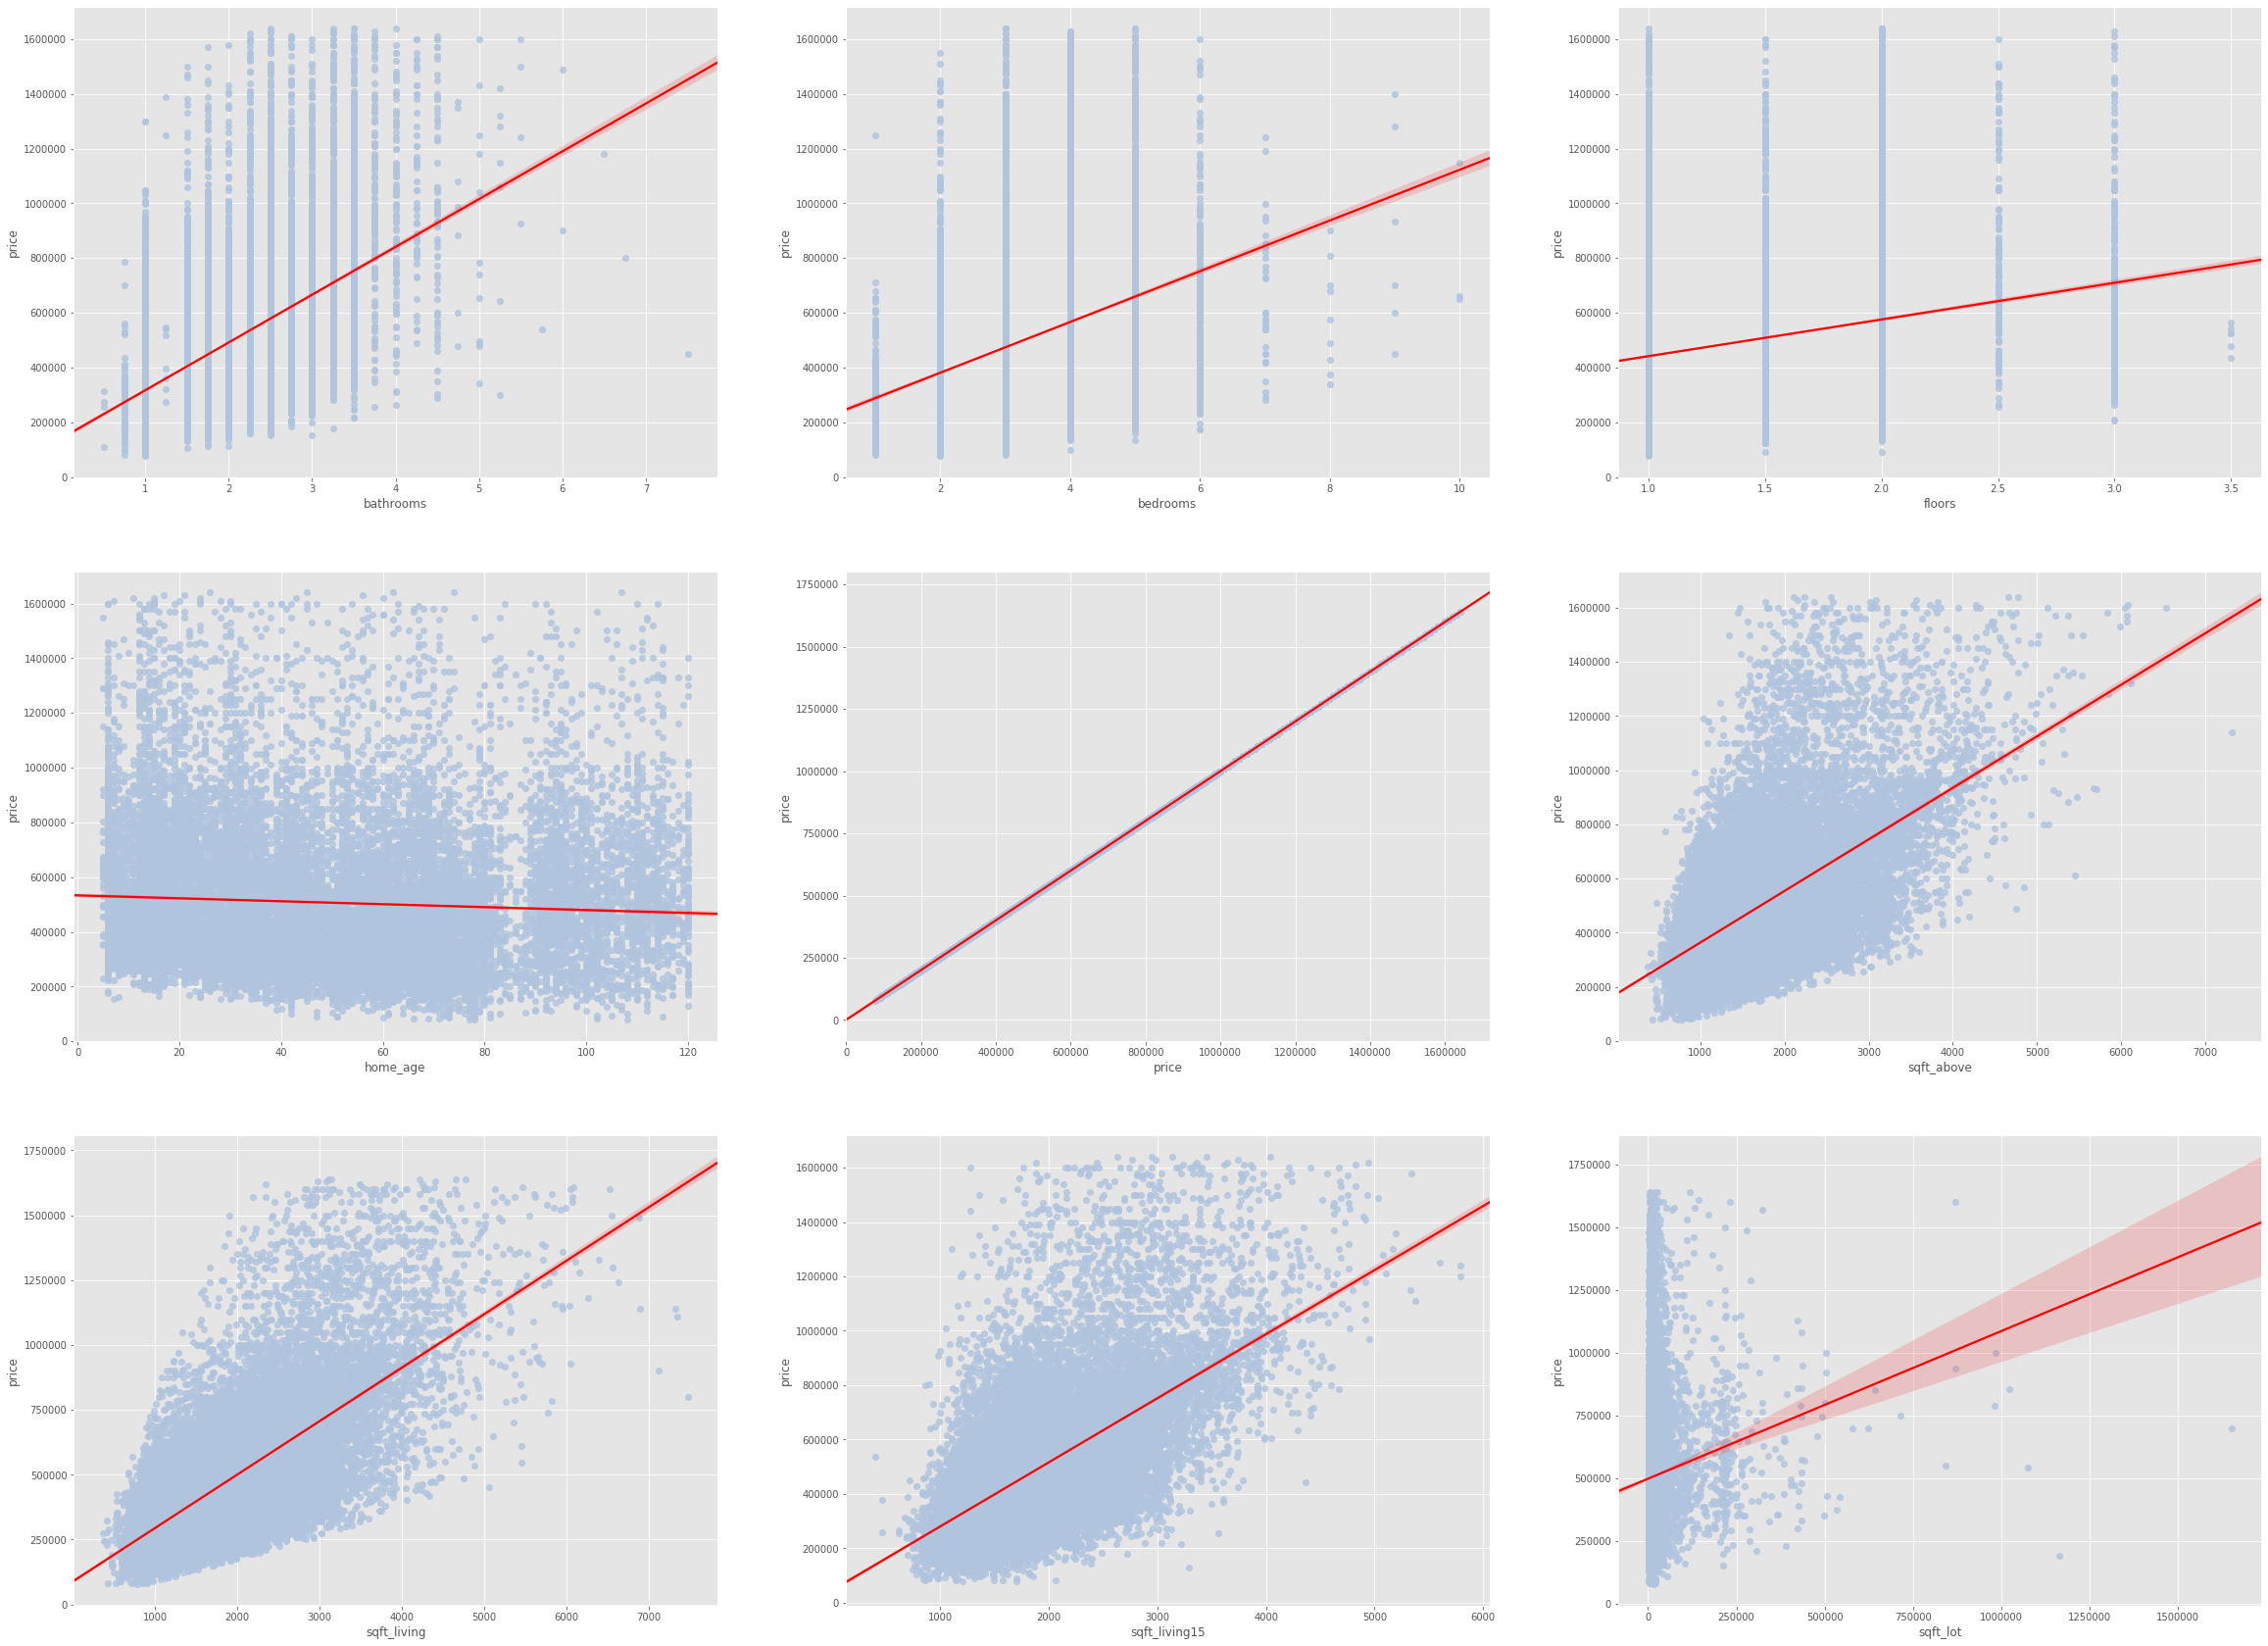

In [232]:
fig, axes = plt.subplots(3, 3,figsize=(40,30))
axes = axes.flatten()
for i, (feature, ax) in enumerate(zip(df_num, axes), 1):
    sns.regplot(data=df_num, x=feature, y='price', ax=ax,scatter_kws = {'color': 'lightsteelblue'}
                ,line_kws = {'color': 'red'})

In [233]:
#sqft_lot appears to have many outliers
#Otherwise, it is difficult to tell
#Going to leverage z-score

In [234]:
df_no_outliers = df_num[(np.abs(stats.zscore(df_num)) < 3).all(axis=1)]
df_no_outliers

,bathrooms,bedrooms,floors,home_age,price,sqft_above,sqft_living,sqft_living15,sqft_lot,sqft_lot15
0,1.00,3,1.0,65,221900.0,1180,1180,1340,5650,5650
1,2.25,3,2.0,69,538000.0,2170,2570,1690,7242,7639
2,1.00,2,1.0,87,180000.0,770,770,2720,10000,8062
3,3.00,4,1.0,55,604000.0,1050,1960,1360,5000,5000
4,2.00,3,1.0,33,510000.0,1680,1680,1800,8080,7503
...,...,...,...,...,...,...,...,...,...,...
21183,2.50,3,3.0,11,360000.0,1530,1530,1530,1131,1509
21184,2.50,4,2.0,6,400000.0,2310,2310,1830,5813,7200
21185,0.75,2,2.0,11,402101.0,1020,1020,1020,1350,2007
21186,2.50,3,2.0,16,400000.0,1600,1600,1410,2388,1287


In [235]:
#Repeating regplots
#Appear more normal

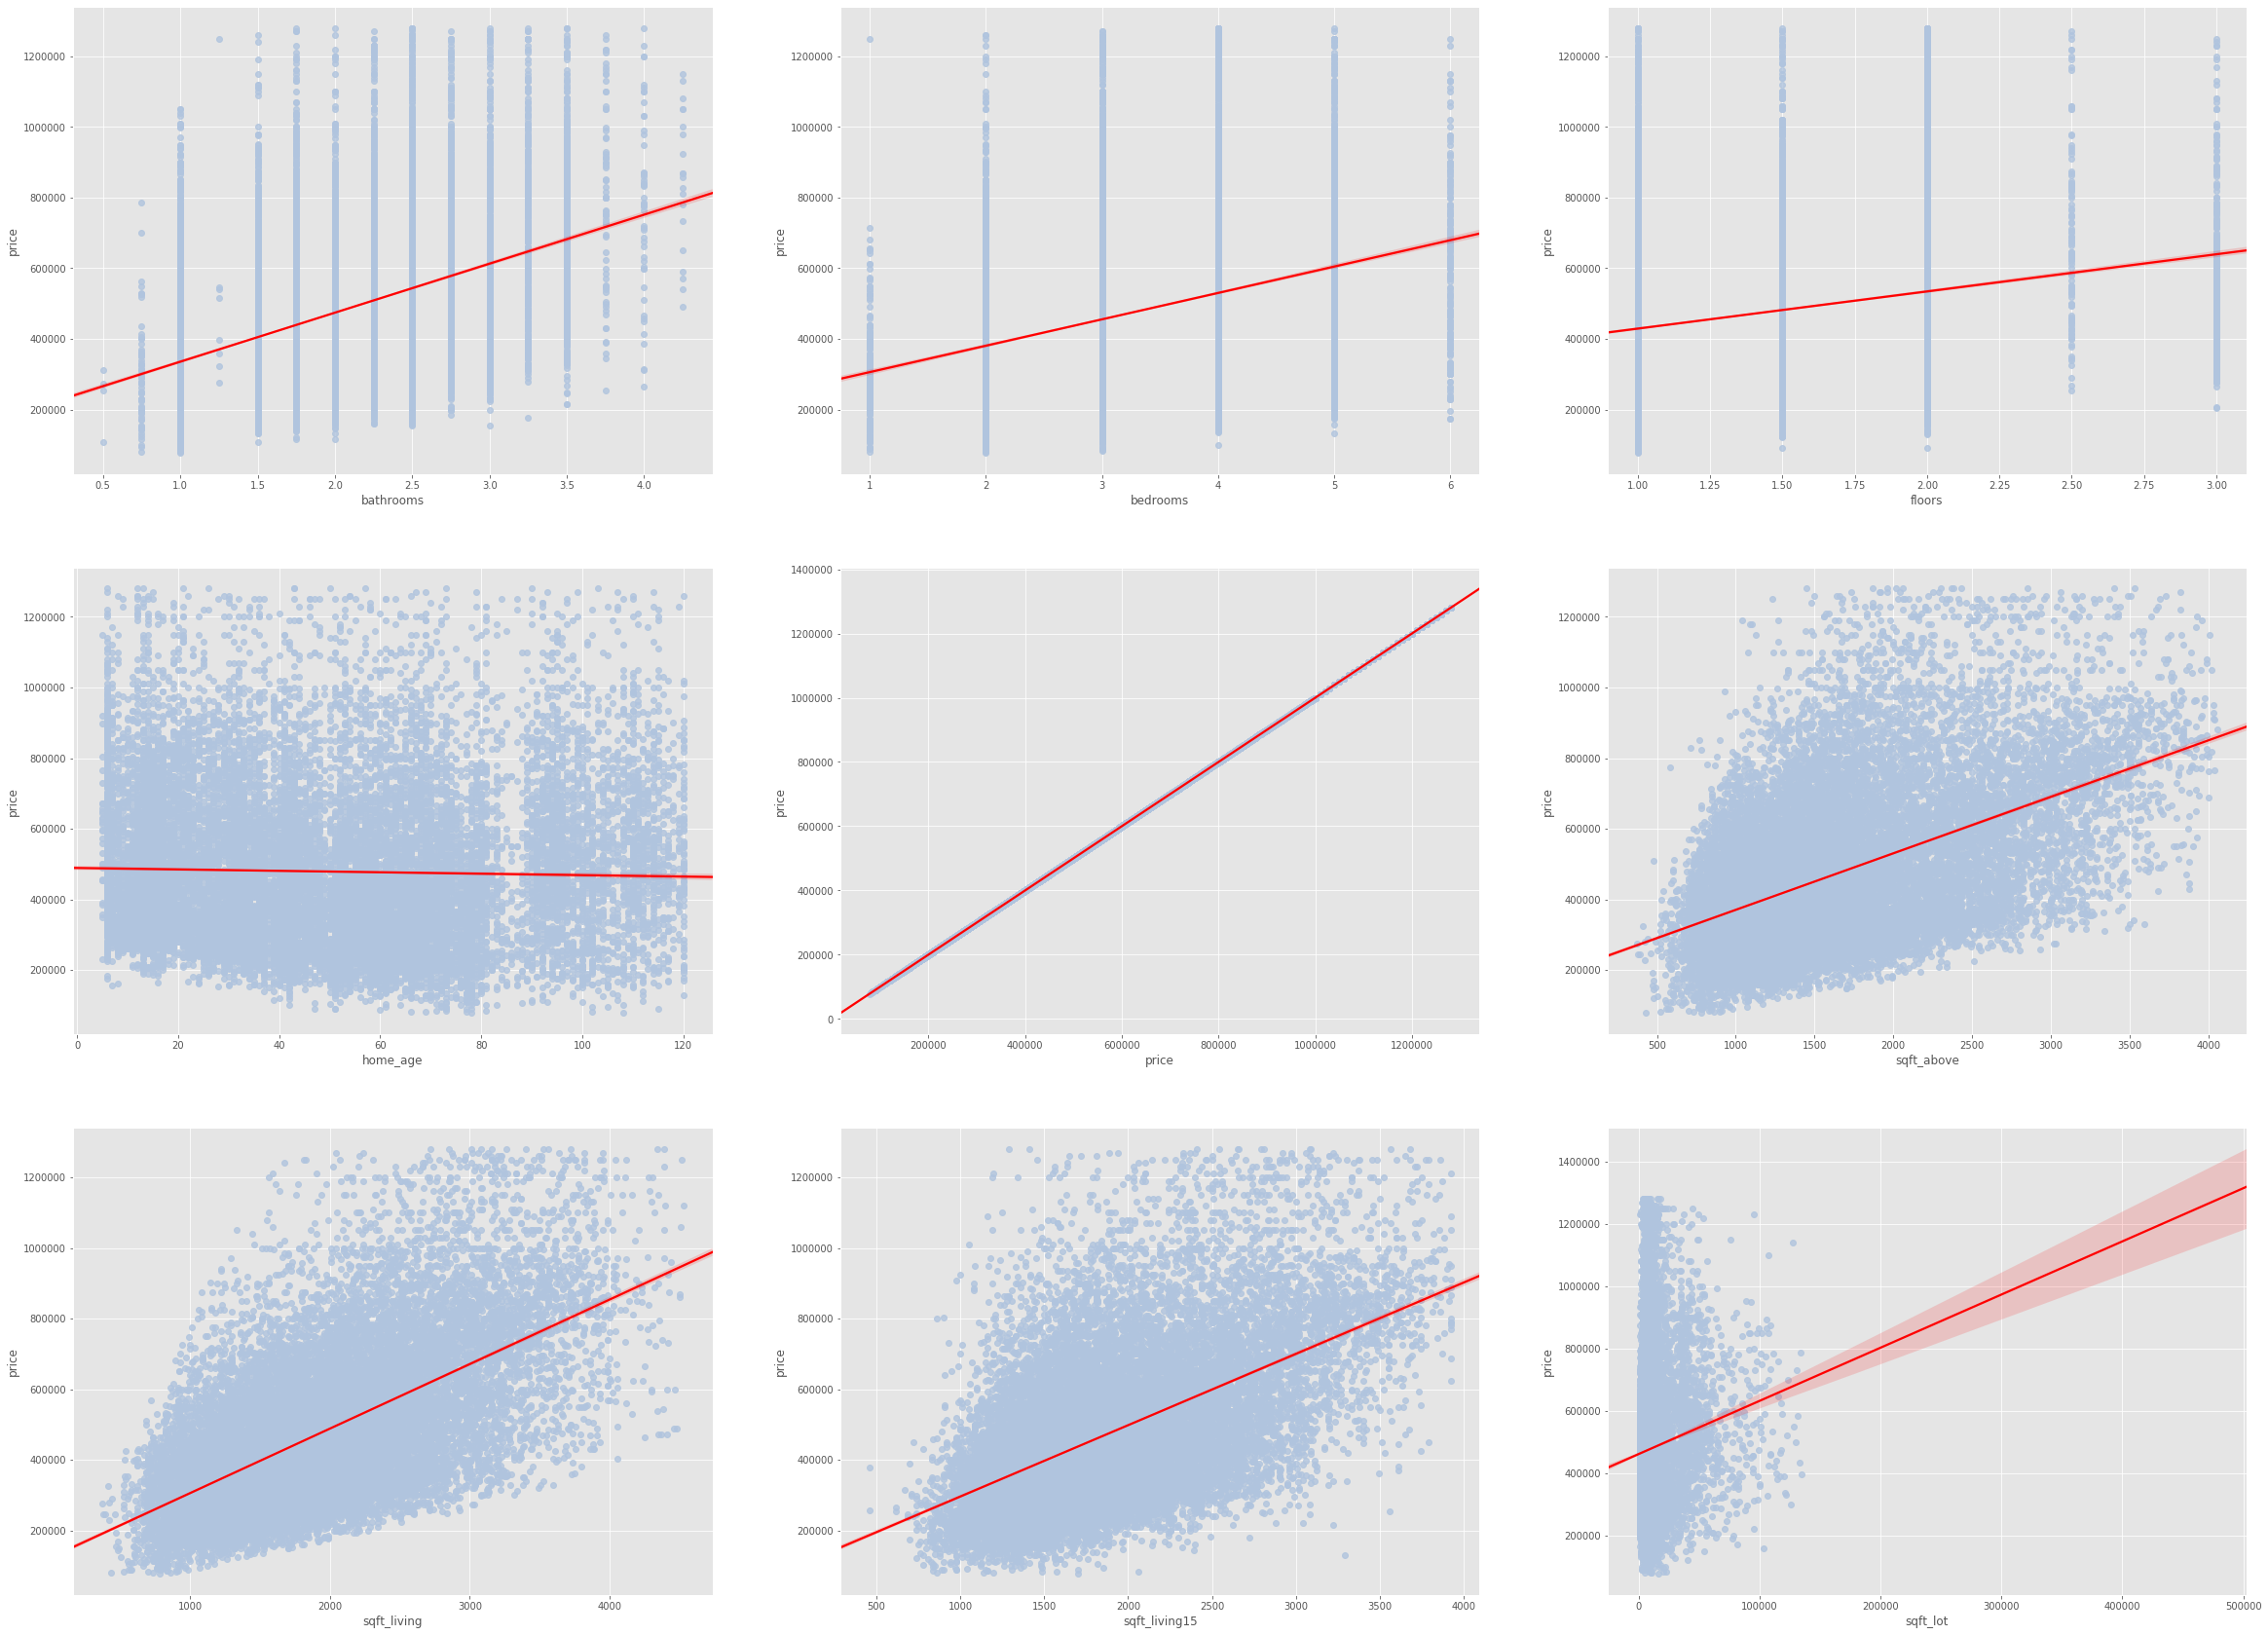

In [236]:
fig, axes = plt.subplots(3, 3,figsize=(40,30))
axes = axes.flatten()
for i, (feature, ax) in enumerate(zip(df_no_outliers, axes), 1):
    sns.regplot(data=df_no_outliers, x=feature, y='price', ax=ax,scatter_kws = {'color': 'lightsteelblue'}
                ,line_kws = {'color': 'red'})

In [237]:
#Performing simple linear regression for each variable

In [238]:
linreg = LinearRegression() 

for col in df_no_outliers.columns:
    
    x = df_no_outliers[col].values.reshape(-1, 1) 
    y = df_no_outliers['price'].values.reshape(-1, 1) 
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    print(col,"v. price")
    print('r-squared:', round(r_sq,2))
    print("")

bathrooms v. price
r-squared: 0.19

bedrooms v. price
r-squared: 0.09

floors v. price
r-squared: 0.07

home_age v. price
r-squared: 0.0

price v. price
r-squared: 1.0

sqft_above v. price
r-squared: 0.25

sqft_living v. price
r-squared: 0.37

sqft_living15 v. price
r-squared: 0.3

sqft_lot v. price
r-squared: 0.01

sqft_lot15 v. price
r-squared: 0.01



In [239]:
#sqft_living, sqft_living15, sqft_above and bathrooms are most highly correlated w/price

In [240]:
#Saving df with outliers removed

df_no_outliers = df[(np.abs(stats.zscore(df_num)) < 3).all(axis=1)]
df_no_outliers.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,yr_sold,home_age,yrs_since_reno,neighborhood,has_basement
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0,1340,5650,2014,65,2020,Seattle,0.0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400,1690,7639,2014,69,29,Seattle,1.0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0,2720,8062,2015,87,2020,Kenmore,0.0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910,1360,5000,2014,55,2020,Seattle,1.0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0,1800,7503,2015,33,2020,Sammamish,0.0


# Creating dummy variables

In [241]:
df_no_outliers.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,yr_sold,home_age,yrs_since_reno,neighborhood,has_basement
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0,1340,5650,2014,65,2020,Seattle,0.0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400,1690,7639,2014,69,29,Seattle,1.0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0,2720,8062,2015,87,2020,Kenmore,0.0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910,1360,5000,2014,55,2020,Seattle,1.0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0,1800,7503,2015,33,2020,Sammamish,0.0


In [242]:
df_clean = df_no_outliers.copy()
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21188 entries, 0 to 21187
Data columns (total 8 columns):
yrs_since_reno    21188 non-null int64
waterfront        21188 non-null float64
view              21188 non-null float64
condition         21188 non-null int64
grade             21188 non-null int64
has_basement      21188 non-null float64
neighborhood      21188 non-null object
yr_sold           21188 non-null int64
dtypes: float64(3), int64(4), object(1)
memory usage: 1.3+ MB


In [243]:
#converting category columns to objects 

for column in list(df_cat.columns)[1:]:
    df_clean[column] = df_clean[column].astype(str)
    
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19942 entries, 0 to 21187
Data columns (total 19 columns):
price             19942 non-null float64
bedrooms          19942 non-null int64
bathrooms         19942 non-null float64
sqft_living       19942 non-null int64
sqft_lot          19942 non-null int64
floors            19942 non-null float64
waterfront        19942 non-null object
view              19942 non-null object
condition         19942 non-null object
grade             19942 non-null object
sqft_above        19942 non-null int64
sqft_basement     19942 non-null int64
sqft_living15     19942 non-null int64
sqft_lot15        19942 non-null int64
yr_sold           19942 non-null object
home_age          19942 non-null int64
yrs_since_reno    19942 non-null int64
neighborhood      19942 non-null object
has_basement      19942 non-null object
dtypes: float64(3), int64(9), object(7)
memory usage: 3.0+ MB


In [244]:
df_clean = pd.get_dummies(df_clean,drop_first=True)

In [245]:
#checking column names

df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'home_age', 'yrs_since_reno', 'waterfront_1.0', 'view_1.0', 'view_2.0',
       'view_3.0', 'view_4.0', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'grade_11', 'grade_3', 'grade_4', 'grade_5', 'grade_6',
       'grade_7', 'grade_8', 'grade_9', 'yr_sold_2015',
       'neighborhood_Bellevue', 'neighborhood_Black Diamond',
       'neighborhood_Bothell', 'neighborhood_Carnation', 'neighborhood_Duvall',
       'neighborhood_Enumclaw', 'neighborhood_Fall City',
       'neighborhood_Federal Way', 'neighborhood_Issaquah',
       'neighborhood_Kenmore', 'neighborhood_Kent', 'neighborhood_Kirkland',
       'neighborhood_Maple Valley', 'neighborhood_Medina',
       'neighborhood_Mercer Island', 'neighborhood_North Bend',
       'neighborhood_Redmond', 'neighborhood_Renton', 'neighborhood_Sammamish',
       'neighborhood_Sea

In [246]:
#removing spaces from column names

df_clean.columns = df_clean.columns.str.replace(' ', '_')

In [247]:
#removing periods from column names

df_clean.columns = df_clean.columns.str.replace('.', '_')

In [248]:
df_clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'home_age', 'yrs_since_reno', 'waterfront_1_0', 'view_1_0', 'view_2_0',
       'view_3_0', 'view_4_0', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'grade_11', 'grade_3', 'grade_4', 'grade_5', 'grade_6',
       'grade_7', 'grade_8', 'grade_9', 'yr_sold_2015',
       'neighborhood_Bellevue', 'neighborhood_Black_Diamond',
       'neighborhood_Bothell', 'neighborhood_Carnation', 'neighborhood_Duvall',
       'neighborhood_Enumclaw', 'neighborhood_Fall_City',
       'neighborhood_Federal_Way', 'neighborhood_Issaquah',
       'neighborhood_Kenmore', 'neighborhood_Kent', 'neighborhood_Kirkland',
       'neighborhood_Maple_Valley', 'neighborhood_Medina',
       'neighborhood_Mercer_Island', 'neighborhood_North_Bend',
       'neighborhood_Redmond', 'neighborhood_Renton', 'neighborhood_Sammamish',
       'neighborhood_Sea

# Train-Test Split

In [249]:
# Import
from sklearn.model_selection import train_test_split

In [250]:
# Defining the problem
y = df_clean.price
X = df_clean.drop('price',axis=1)

In [251]:
#split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [252]:
#Merging for modeling

train_df = X_train.copy()
train_df['price'] = y_train
train_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_living15,sqft_lot15,home_age,...,neighborhood_North_Bend,neighborhood_Redmond,neighborhood_Renton,neighborhood_Sammamish,neighborhood_Seattle,neighborhood_Snoqualmie,neighborhood_Vashon,neighborhood_Woodinville,has_basement_1_0,price
15489,4,2.5,2150,5397,2.0,2150,0,2260,5080,22,...,0,0,1,0,0,0,0,0,0,400000.0
20615,3,2.5,1509,1114,3.0,1509,0,1509,2431,6,...,0,0,0,0,1,0,0,0,0,420000.0
2128,2,1.0,1088,8453,1.0,1088,0,1088,8016,68,...,0,0,0,0,0,0,0,0,0,238000.0
12438,3,2.5,1740,6992,2.0,1740,0,1260,6825,30,...,0,0,0,0,0,0,0,0,0,261500.0
6282,3,1.0,1250,8314,1.0,1250,0,1188,7700,62,...,0,0,1,0,0,0,0,0,0,144000.0


# Baseline Model

In [253]:
outcome = 'price'
x_cols = list(X_train.columns)

In [254]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

In [255]:
model = ols(formula=formula, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     839.3
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:36:09   Log-Likelihood:            -2.0822e+05
No. Observations:               15953   AIC:                         4.165e+05
Df Residuals:                   15900   BIC:                         4.170e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    2.34e+04   2.76e+04      0.848      0.396   -3.07e+04    7.75e+04
bedrooms                    -1.17e+04   1402.428     -8.340      0.000   -1.44e+04   -8947.023
bathrooms                   2.514e+04   2292.748     10.963      0.000    2.06e+04    2.96e+04
sqft_living                   46.2143      1.960     23.573      0.000      42.372      50.057
sqft_lot                       0.7459      0.135      5.537      0.000       0.482       1.010
floors                      3.649e+04   2534.266     14.397      0.000    3.15e+04    4.15e+04
sqft_above                    41.6022      2.302     18.070      0.000      37.089      46.115
sqft_basement                  4.6121      3.100      1.488      0.137      -1.465      10.689
sqft_living15                 40.6389      2.645     15.362      0.000      35.453      45.824
sqft_lot15                    -1.5611      0.177     -8.830      0.000      -1.908      -1.215
home_age                    1791.7445     50.178     35.708      0.000    1693.390    1890.099
yrs_since_reno               -13.1809      2.724     -4.839      0.000     -18.520      -7.842
waterfront_1_0              1.142e+05   2.02e+04      5.651      0.000    7.46e+04    1.54e+05
view_1_0                    5.359e+04   7659.978      6.996      0.000    3.86e+04    6.86e+04
view_2_0                    4.463e+04   4771.143      9.354      0.000    3.53e+04     5.4e+04
view_3_0                    6.985e+04   7103.731      9.833      0.000    5.59e+04    8.38e+04
view_4_0                    1.632e+05   1.16e+04     14.028      0.000     1.4e+05    1.86e+05
condition_2                 6.114e+04   2.63e+04      2.320      0.020    9491.307    1.13e+05
condition_3                 1.031e+05   2.43e+04      4.239      0.000    5.54e+04    1.51e+05
condition_4                 1.246e+05   2.43e+04      5.119      0.000    7.69e+04    1.72e+05
condition_5                 1.642e+05   2.45e+04      6.701      0.000    1.16e+05    2.12e+05
grade_11                    7.024e+04   1.39e+04      5.056      0.000     4.3e+04    9.75e+04
grade_3                    -2.434e+05   1.14e+05     -2.141      0.032   -4.66e+05   -2.05e+04
grade_4                    -3.362e+05   2.53e+04    -13.265      0.000   -3.86e+05   -2.87e+05
grade_5                    -3.274e+05   1.11e+04    -29.387      0.000   -3.49e+05   -3.06e+05
grade_6                    -3.079e+05   7361.889    -41.819      0.000   -3.22e+05   -2.93e+05
grade_7                    -2.358e+05   6300.612    -37.423      0.000   -2.48e+05   -2.23e+05
grade_8                    -1.674e+05   5741.092    -29.167      0.000   -1.79e+05   -1.56e+05
grade_9                    -7.039e+04   5639.276    -12.481      0.000   -8.14e+04   -5.93e+04
yr_sold_2015                2.133e+04   191

In [256]:
linreg = LinearRegression() 
linreg.fit(X_train, y_train)
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [257]:
train_mse = mean_squared_error(y_train, y_hat_train) 
test_mse = mean_squared_error(y_test, y_hat_test) 
print('Train Mean Squarred Error:', train_mse) 
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 12718062819.71141
Test Mean Squarred Error: 13069390908.513176


In [258]:
test_mse-train_mse #large difference in RMSEs

351328088.80176544

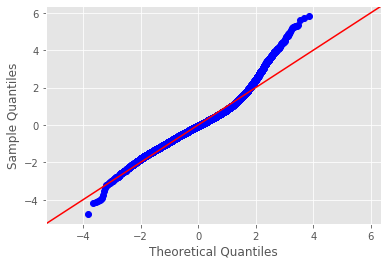

In [259]:
#Somewhat skewed distribution of residuals

plt.style.use('ggplot')

resid = model.resid

fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

In [260]:
#R-sq is low at 0.753 (adj is 0.752)
#Multiple variables with a p-value greater than 0.05

print(("number of features w/p-value > 0.05: ") + str(len(model.pvalues[1:][model.pvalues>0.05])))
print(("total number of features: ") + str(len(x_cols)))

number of features w/p-value > 0.05: 3
total number of features: 53


# Model 2: Removing high p-values

## Removing features

In [261]:
model.pvalues[1:][(model.pvalues>0.05)]

sqft_basement            0.136879
neighborhood_Enumclaw    0.355327
neighborhood_Kent        0.051993
dtype: float64

In [262]:
remove_features = list(model.pvalues[1:][(model.pvalues>0.05)].index)
remove_features

['sqft_basement', 'neighborhood_Enumclaw', 'neighborhood_Kent']

In [263]:
removed_high_p_features_df = train_df[train_df.columns.difference(remove_features,sort=False)]
removed_high_p_features_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_living15,sqft_lot15,home_age,yrs_since_reno,...,neighborhood_North_Bend,neighborhood_Redmond,neighborhood_Renton,neighborhood_Sammamish,neighborhood_Seattle,neighborhood_Snoqualmie,neighborhood_Vashon,neighborhood_Woodinville,has_basement_1_0,price
15489,4,2.50,2150,5397,2.0,2150,2260,5080,22,2020,...,0,0,1,0,0,0,0,0,0,400000.0
20615,3,2.50,1509,1114,3.0,1509,1509,2431,6,2020,...,0,0,0,0,1,0,0,0,0,420000.0
2128,2,1.00,1088,8453,1.0,1088,1088,8016,68,11,...,0,0,0,0,0,0,0,0,0,238000.0
12438,3,2.50,1740,6992,2.0,1740,1260,6825,30,2020,...,0,0,0,0,0,0,0,0,0,261500.0
6282,3,1.00,1250,8314,1.0,1250,1188,7700,62,2020,...,0,0,1,0,0,0,0,0,0,144000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11959,3,1.00,1060,10042,1.0,1060,1130,10925,63,2020,...,0,0,0,0,1,0,0,0,0,219950.0
12682,4,2.50,4020,44431,2.0,4020,3440,52900,33,2020,...,0,0,0,0,0,0,0,1,0,818000.0
5716,3,1.75,2390,9000,1.0,1500,2040,9000,45,2020,...,0,1,0,0,0,0,0,0,1,570000.0
911,4,2.50,2780,10480,1.0,1390,2860,10506,53,2020,...,0,0,0,0,0,0,0,0,1,990000.0


## Model

In [264]:
outcome = 'price'
x_cols_2 = list(removed_high_p_features_df.columns.drop('price'))

In [265]:
predictors2 = '+'.join(x_cols_2)
formula2 = outcome + '~' + predictors2

In [266]:
model2 = ols(formula=formula2, data=removed_high_p_features_df).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     872.7
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:36:10   Log-Likelihood:            -2.0822e+05
No. Observations:               15953   AIC:                         4.165e+05
Df Residuals:                   15902   BIC:                         4.169e+05
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    3.01e+04   2.74e+04      1.100      0.272   -2.36e+04    8.38e+04
bedrooms                   -1.172e+04   1402.362     -8.356      0.000   -1.45e+04   -8969.832
bathrooms                   2.516e+04   2292.854     10.972      0.000    2.07e+04    2.97e+04
sqft_living                   50.7832      4.649     10.924      0.000      41.671      59.896
sqft_lot                       0.7504      0.135      5.572      0.000       0.486       1.014
floors                      3.645e+04   2534.342     14.382      0.000    3.15e+04    4.14e+04
sqft_above                    37.0200      5.097      7.263      0.000      27.029      47.011
sqft_living15                 40.7264      2.643     15.411      0.000      35.547      45.906
sqft_lot15                    -1.5683      0.177     -8.875      0.000      -1.915      -1.222
home_age                    1790.7176     50.177     35.688      0.000    1692.365    1889.070
yrs_since_reno               -13.1730      2.723     -4.838      0.000     -18.510      -7.836
waterfront_1_0              1.142e+05   2.02e+04      5.650      0.000    7.46e+04    1.54e+05
view_1_0                    5.355e+04   7659.986      6.991      0.000    3.85e+04    6.86e+04
view_2_0                    4.462e+04   4761.589      9.371      0.000    3.53e+04     5.4e+04
view_3_0                    6.986e+04   7094.714      9.846      0.000    5.59e+04    8.38e+04
view_4_0                    1.632e+05   1.16e+04     14.030      0.000     1.4e+05    1.86e+05
condition_2                 6.094e+04   2.63e+04      2.313      0.021    9291.116    1.13e+05
condition_3                  1.03e+05   2.43e+04      4.235      0.000    5.53e+04    1.51e+05
condition_4                 1.246e+05   2.43e+04      5.118      0.000    7.69e+04    1.72e+05
condition_5                 1.642e+05   2.45e+04      6.703      0.000    1.16e+05    2.12e+05
grade_11                    7.029e+04   1.39e+04      5.059      0.000    4.31e+04    9.75e+04
grade_3                    -2.405e+05   1.13e+05     -2.122      0.034   -4.63e+05   -1.83e+04
grade_4                    -3.357e+05   2.53e+04    -13.246      0.000   -3.85e+05   -2.86e+05
grade_5                    -3.275e+05   1.11e+04    -29.400      0.000   -3.49e+05   -3.06e+05
grade_6                    -3.079e+05   7362.012    -41.821      0.000   -3.22e+05   -2.93e+05
grade_7                    -2.357e+05   6300.667    -37.403      0.000   -2.48e+05   -2.23e+05
grade_8                    -1.674e+05   5741.299    -29.153      0.000   -1.79e+05   -1.56e+05
grade_9                    -7.045e+04   5639.502    -12.493      0.000   -8.15e+04   -5.94e+04
yr_sold_2015                2.136e+04   1917.797     11.140      0.000    1.76e+04    2.51e+04
neighborhood_Bellevue       2.797e+05   478

In [267]:
#No change from baseline model R2

In [268]:
X_train2 = removed_high_p_features_df.drop('price',axis=1)
y_train2 = removed_high_p_features_df.price

X_test2 = X_test[x_cols_2]
y_test2 = y_test.copy()

linreg2 = LinearRegression() 
linreg2.fit(X_train2, y_train2)
y_hat_train2 = linreg2.predict(X_train2)
y_hat_test2 = linreg2.predict(X_test2)

train_mse2 = mean_squared_error(y_train2, y_hat_train2) 
test_mse2 = mean_squared_error(y_test2, y_hat_test2) 
print('Train Mean Squarred Error:', train_mse2) 
print('Test Mean Squarred Error:', test_mse2)

test_mse2-train_mse2 #Lower difference in RMSEs

Train Mean Squarred Error: 12721166231.06952
Test Mean Squarred Error: 13072015483.22964


350849252.1601181

# Feature correlation

## Determining features w/highest correlation

In [269]:
#Determining which features are most highly correlated

In [270]:
df_corr = removed_high_p_features_df.corr().loc[['price']].abs().stack().reset_index().sort_values(0, ascending=False)
df_corr.set_index('level_1',inplace=True)
# high_corr_df_v_price_only.reset_index(inplace=True,drop=True)
df_corr.drop('level_0',axis=1,inplace=True)
df_corr.drop('price',axis=0,inplace=True)
df_corr

,0
level_1,
sqft_living,0.613688
sqft_living15,0.550683
sqft_above,0.502659
bathrooms,0.439178
grade_9,0.373688
grade_7,0.321723
bedrooms,0.291304
grade_6,0.272541
floors,0.259332


In [271]:
#Taking top 10

df_corr[:10]

,0
level_1,
sqft_living,0.613688
sqft_living15,0.550683
sqft_above,0.502659
bathrooms,0.439178
grade_9,0.373688
grade_7,0.321723
bedrooms,0.291304
grade_6,0.272541
floors,0.259332


In [272]:
#saving features

high_corr_feat = list(df_corr.index[:10])
high_corr_feat

['sqft_living',
 'sqft_living15',
 'sqft_above',
 'bathrooms',
 'grade_9',
 'grade_7',
 'bedrooms',
 'grade_6',
 'floors',
 'neighborhood_Bellevue']

## Model 3: Top 10 Correlated values

In [273]:
high_corr_feat_columns = high_corr_feat.copy()
high_corr_feat_columns.append('price')

In [274]:
#Re-running the model with these 10 features

high_corr_df = train_df[high_corr_feat_columns]

In [275]:
outcome = 'price'
x_cols_3 = list(high_corr_feat)

In [276]:
predictors3 = '+'.join(x_cols_3)
formula3 = outcome + '~' + predictors3

In [277]:
model3 = ols(formula=formula3, data=high_corr_df).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     1431.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:36:10   Log-Likelihood:            -2.1364e+05
No. Observations:               15953   AIC:                         4.273e+05
Df Residuals:                   15942   BIC:                         4.274e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.175e+05   8592.294     25.308      0.000    2.01e+05    2.34e+05
sqft_living             185.7046      4.250     43.694      0.000     177.374     194.035
sqft_living15            56.5337      3.414     16.558      0.000      49.841      63.226
sqft_above              -76.7388      4.106    -18.691      0.000     -84.786     -68.691
bathrooms             -2.009e+04   2950.791     -6.807      0.000   -2.59e+04   -1.43e+04
grade_9                7.013e+04   4525.135     15.499      0.000    6.13e+04     7.9e+04
grade_7                 -6.3e+04   3361.269    -18.744      0.000   -6.96e+04   -5.64e+04
bedrooms              -2.354e+04   1910.690    -12.321      0.000   -2.73e+04   -1.98e+04
grade_6               -9.389e+04   5431.907    -17.285      0.000   -1.05e+05   -8.32e+04
floors                 4.108e+04   3267.000     12.573      0.000    3.47e+04    4.75e+04
neighborhood_Bellevue  1.517e+05   5551.454     27.328      0.000    1.41e+05    1.63e+05
==============================================================================
Omnibus:                     1529.049   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2215.922
Skew:                           0.751   Prob(JB):                         0.00
Kurtosis:                       4.039   Cond. No.                     2.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [278]:
X_train3 = high_corr_df.drop('price',axis=1)
y_train3 = high_corr_df.price

X_test3 = X_test[x_cols_3]
y_test3 = y_test.copy()

linreg3 = LinearRegression() 
linreg3.fit(X_train3, y_train3)
y_hat_train3 = linreg3.predict(X_train3)
y_hat_test3 = linreg3.predict(X_test3)

train_mse3 = mean_squared_error(y_train3, y_hat_train3) 
test_mse3 = mean_squared_error(y_test3, y_hat_test3) 
print('Train Mean Squarred Error:', train_mse3) 
print('Test Mean Squarred Error:', test_mse3)

test_mse3-train_mse3

Train Mean Squarred Error: 25098817314.639034
Test Mean Squarred Error: 25207948157.215942


109130842.57690811

In [279]:
#Lower R2, but better RMSE

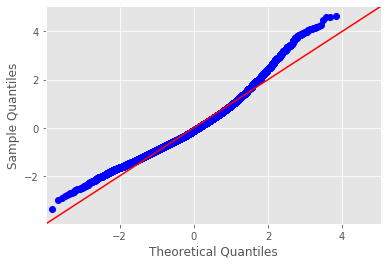

In [280]:
#distribution appears more normal than the baseline model. 
#Baseline model shown below

plt.style.use('ggplot')

resid = model3.resid

fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

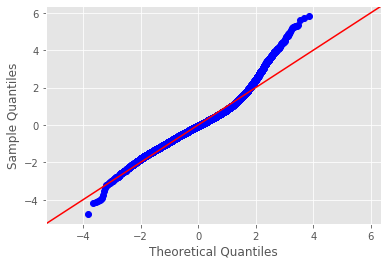

In [281]:
#Skewed distribution of residuals from baseline model

plt.style.use('ggplot')

resid = model.resid

fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

# Log Transformations

## Checking for normal distribution and transforming

In [282]:
high_corr_df.head()

,sqft_living,sqft_living15,sqft_above,bathrooms,grade_9,grade_7,bedrooms,grade_6,floors,neighborhood_Bellevue,price
15489,2150,2260,2150,2.5,0,0,4,0,2.0,0,400000.0
20615,1509,1509,1509,2.5,0,0,3,0,3.0,0,420000.0
2128,1088,1088,1088,1.0,0,0,2,1,1.0,0,238000.0
12438,1740,1260,1740,2.5,0,1,3,0,2.0,0,261500.0
6282,1250,1188,1250,1.0,0,0,3,1,1.0,0,144000.0


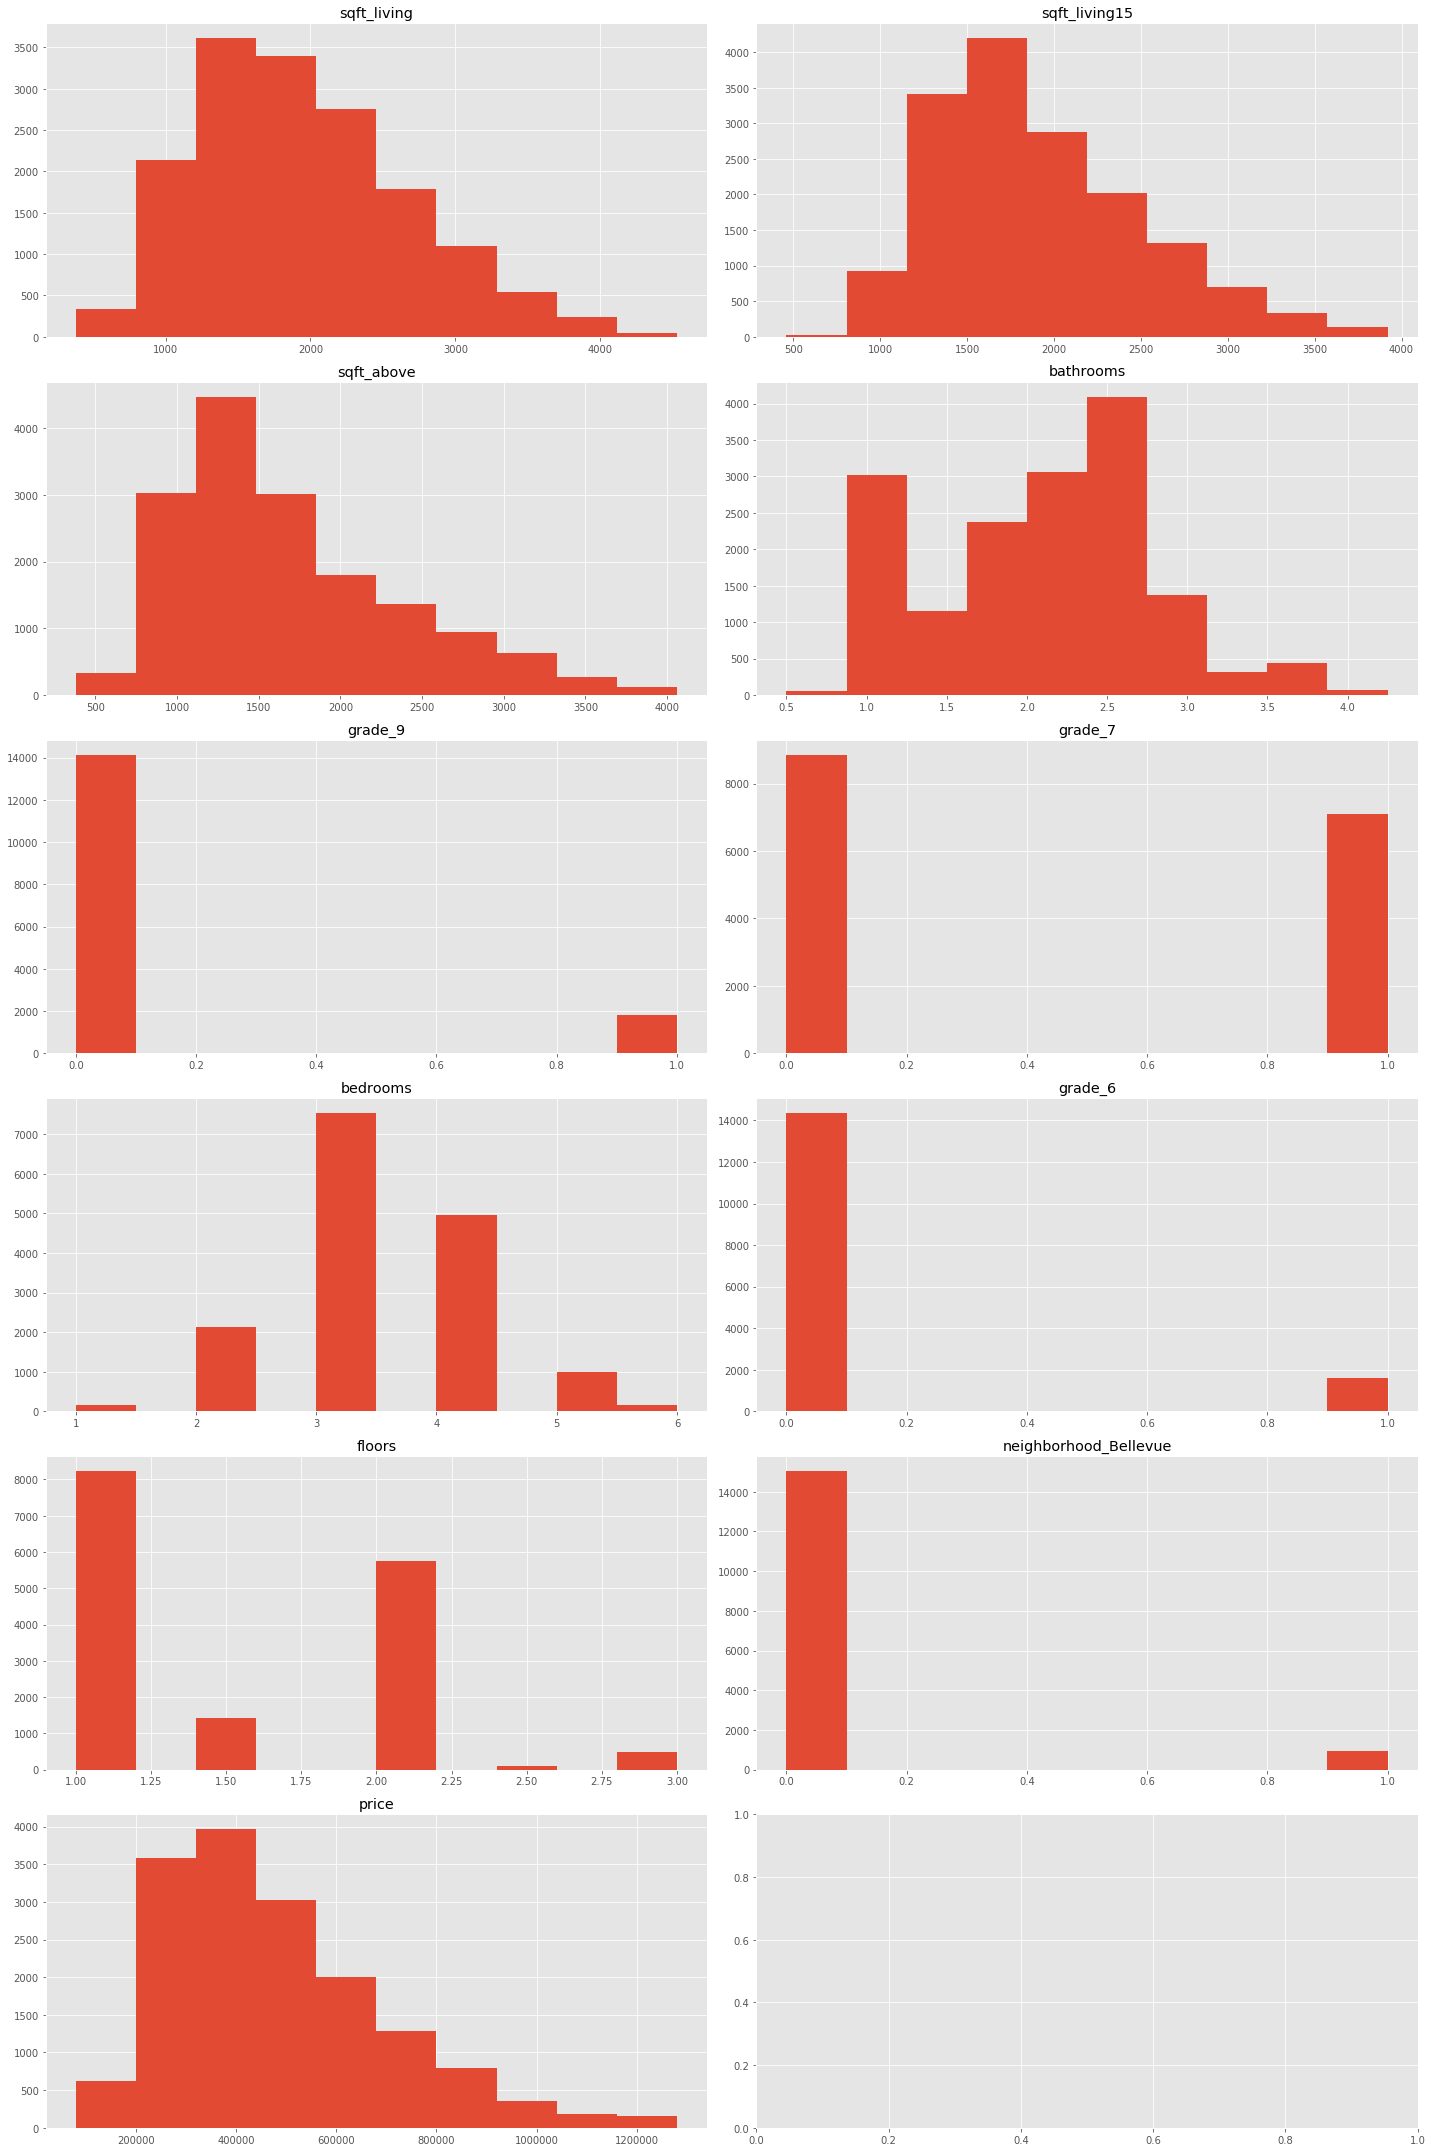

In [283]:
fig, axes = plt.subplots(6,2, figsize=(20,30))
for i,col in enumerate(high_corr_df):
    axes[i//2,i%2].hist(high_corr_df[col])
    axes[i//2,i%2].set_title(f'{col}')
plt.tight_layout()
plt.show()

In [284]:
#Transforming based on skewed distributions

transform = ['price','sqft_living', 'sqft_living15', 'sqft_above','bathrooms']

In [285]:
normalized_df = high_corr_df.copy()

In [286]:
for feat in transform:
    normalized_df[feat] = normalized_df[feat].map(lambda x: np.log(x))

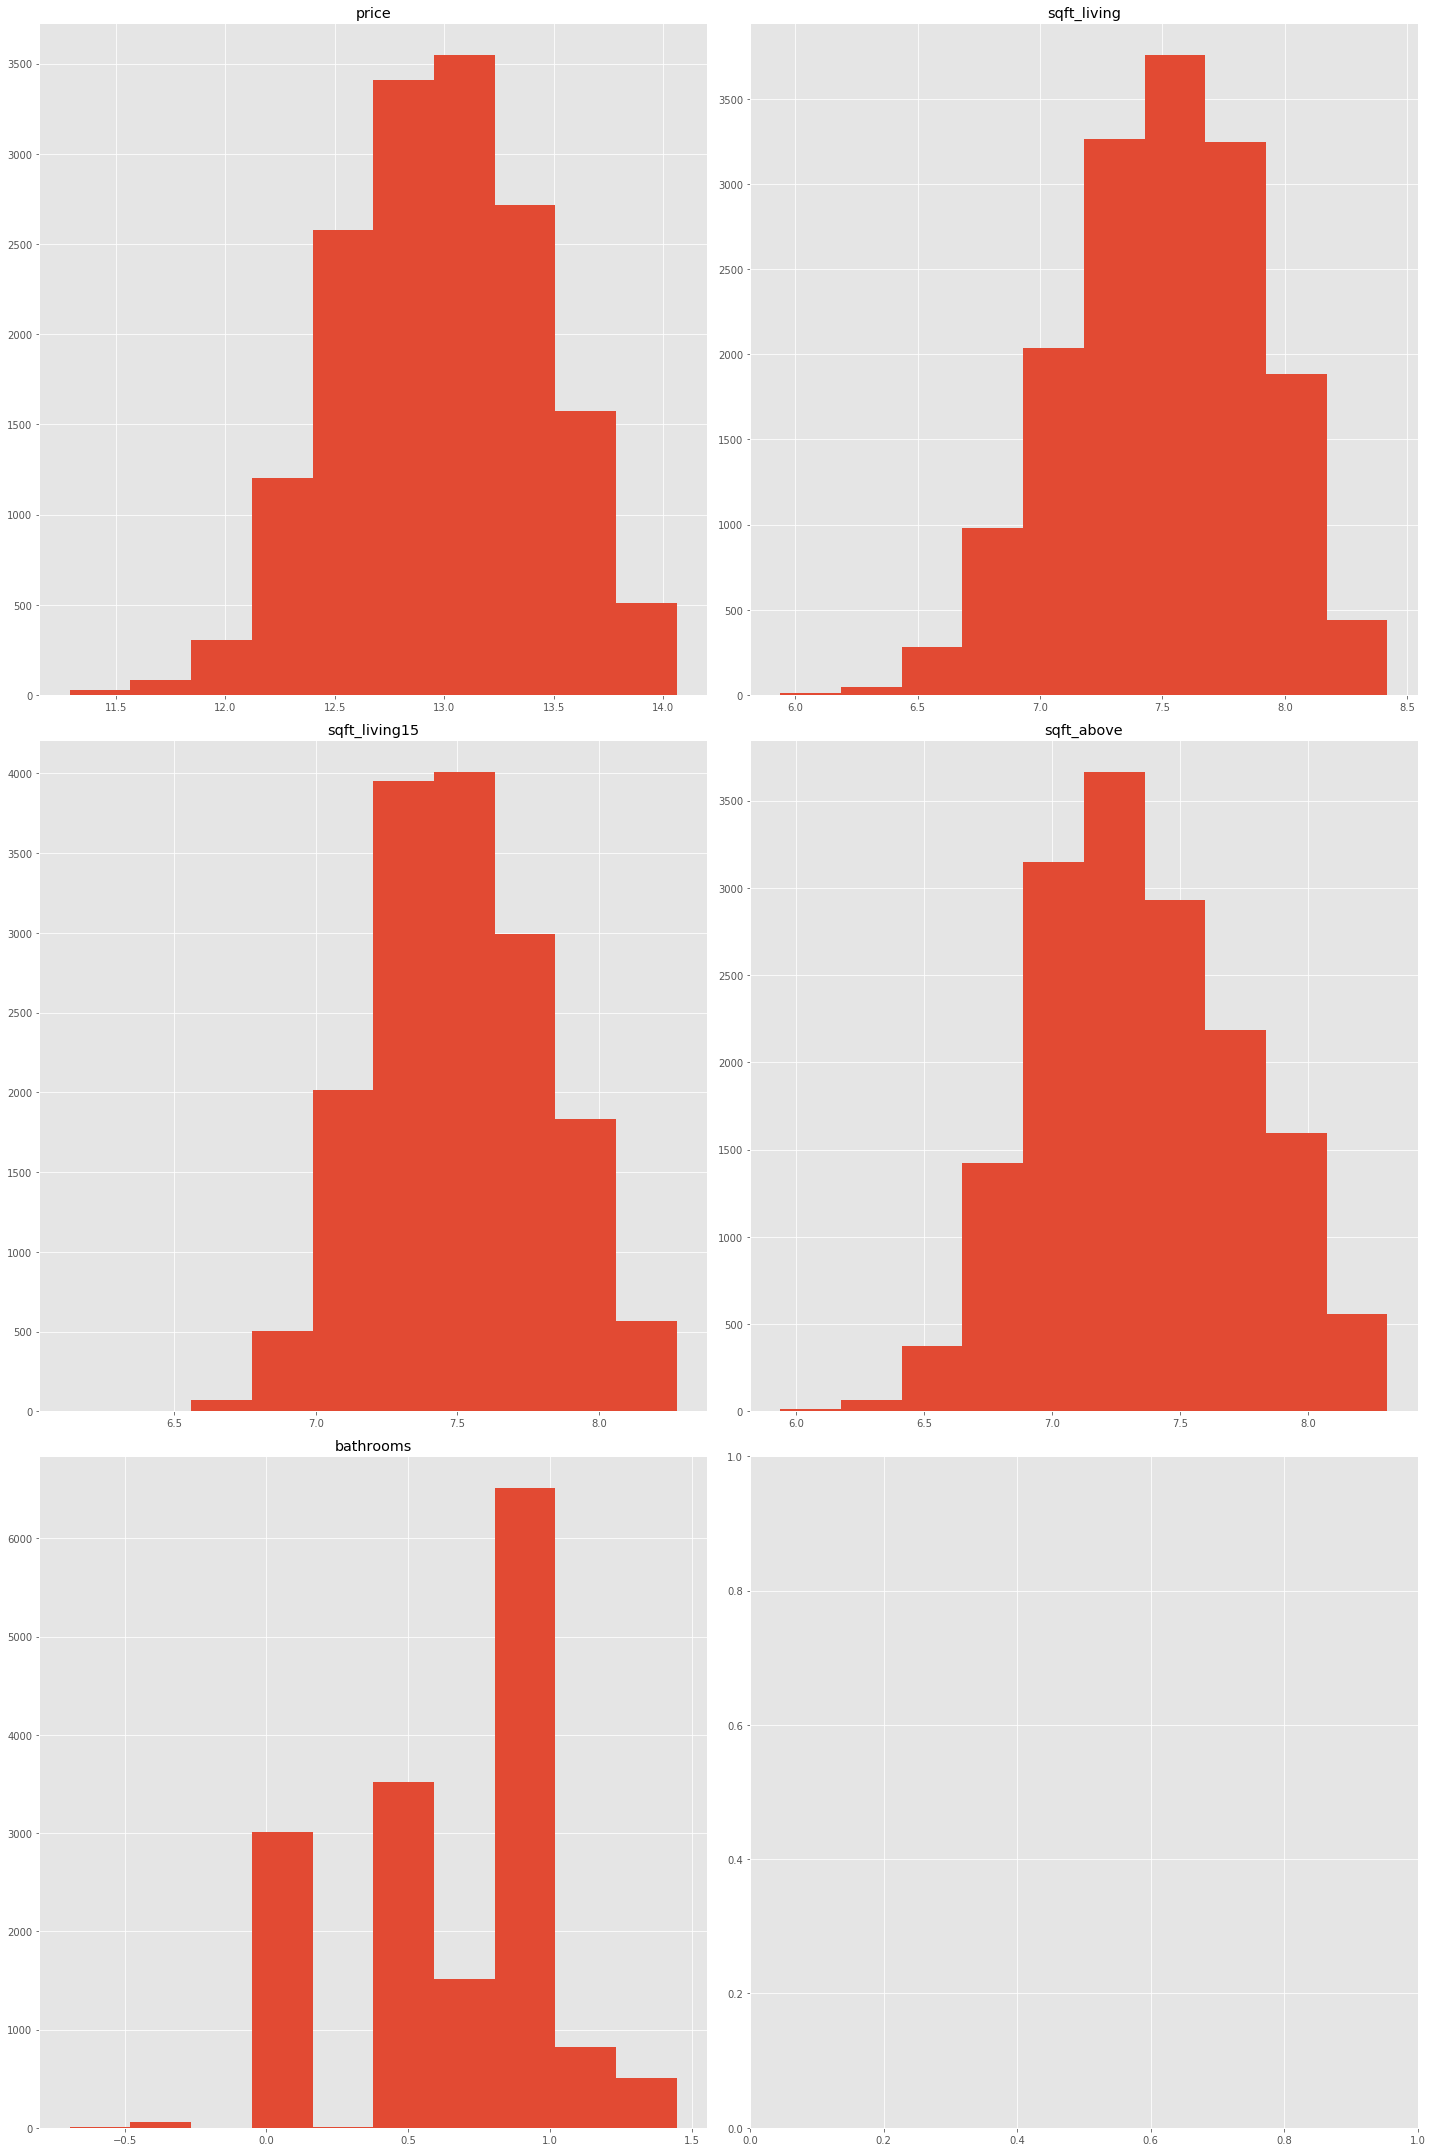

In [287]:
#Checking for improvement in distribution

fig, axes = plt.subplots(3,2, figsize=(20,30))
for i,col in enumerate(transform):
    axes[i//2,i%2].hist(normalized_df[col])
    axes[i//2,i%2].set_title(f'{col}')
plt.tight_layout()
plt.show()

In [288]:
#All look better with the exception of bathrooms

## Model 4

In [289]:
outcome = 'price'
x_cols_4 = list(normalized_df.columns)
x_cols_4.remove('price')

predictors4 = '+'.join(x_cols_4)
formula4 = outcome + '~' + predictors4

model4 = ols(formula=formula4, data=normalized_df).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     1382.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:36:13   Log-Likelihood:                -5041.7
No. Observations:               15953   AIC:                         1.011e+04
Df Residuals:                   15942   BIC:                         1.019e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.0709      0.099     81.120      0.000       7.876       8.266
sqft_living               0.7151      0.017     42.163      0.000       0.682       0.748
sqft_living15             0.2362      0.013     17.557      0.000       0.210       0.263
sqft_above               -0.2873      0.015    -19.508      0.000      -0.316      -0.258
bathrooms                -0.0981      0.011     -8.585      0.000      -0.120      -0.076
grade_9                   0.1318      0.009     14.043      0.000       0.113       0.150
grade_7                  -0.1401      0.007    -20.047      0.000      -0.154      -0.126
bedrooms                 -0.0470      0.004    -11.525      0.000      -0.055      -0.039
grade_6                  -0.2489      0.012    -21.322      0.000      -0.272      -0.226
floors                    0.1052      0.007     15.573      0.000       0.092       0.118
neighborhood_Bellevue     0.3019      0.012     25.995      0.000       0.279       0.325
==============================================================================
Omnibus:                       40.858   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.481
Skew:                          -0.037   Prob(JB):                     5.37e-08
Kurtosis:                       2.788   Cond. No.                         514.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [290]:
X_train4 = normalized_df.drop('price',axis=1)
y_train4 = normalized_df.price

X_test4 = X_test[x_cols_4]
y_test4 = y_test.copy()

linreg4 = LinearRegression() 
linreg4.fit(X_train4, y_train4)
y_hat_train4 = linreg4.predict(X_train4)
y_hat_test4 = linreg4.predict(X_test4)

train_mse4 = mean_squared_error(y_train4, y_hat_train4) 
test_mse4 = mean_squared_error(y_test4, y_hat_test4) 
print('Train Mean Squarred Error:', train_mse4) 
print('Test Mean Squarred Error:', test_mse4)

test_mse4-train_mse4

Train Mean Squarred Error: 0.11016190934053455
Test Mean Squarred Error: 276846945399.63385


276846945399.5237

# Multicolinearity

## Checking for multicolinearity using normalized_df

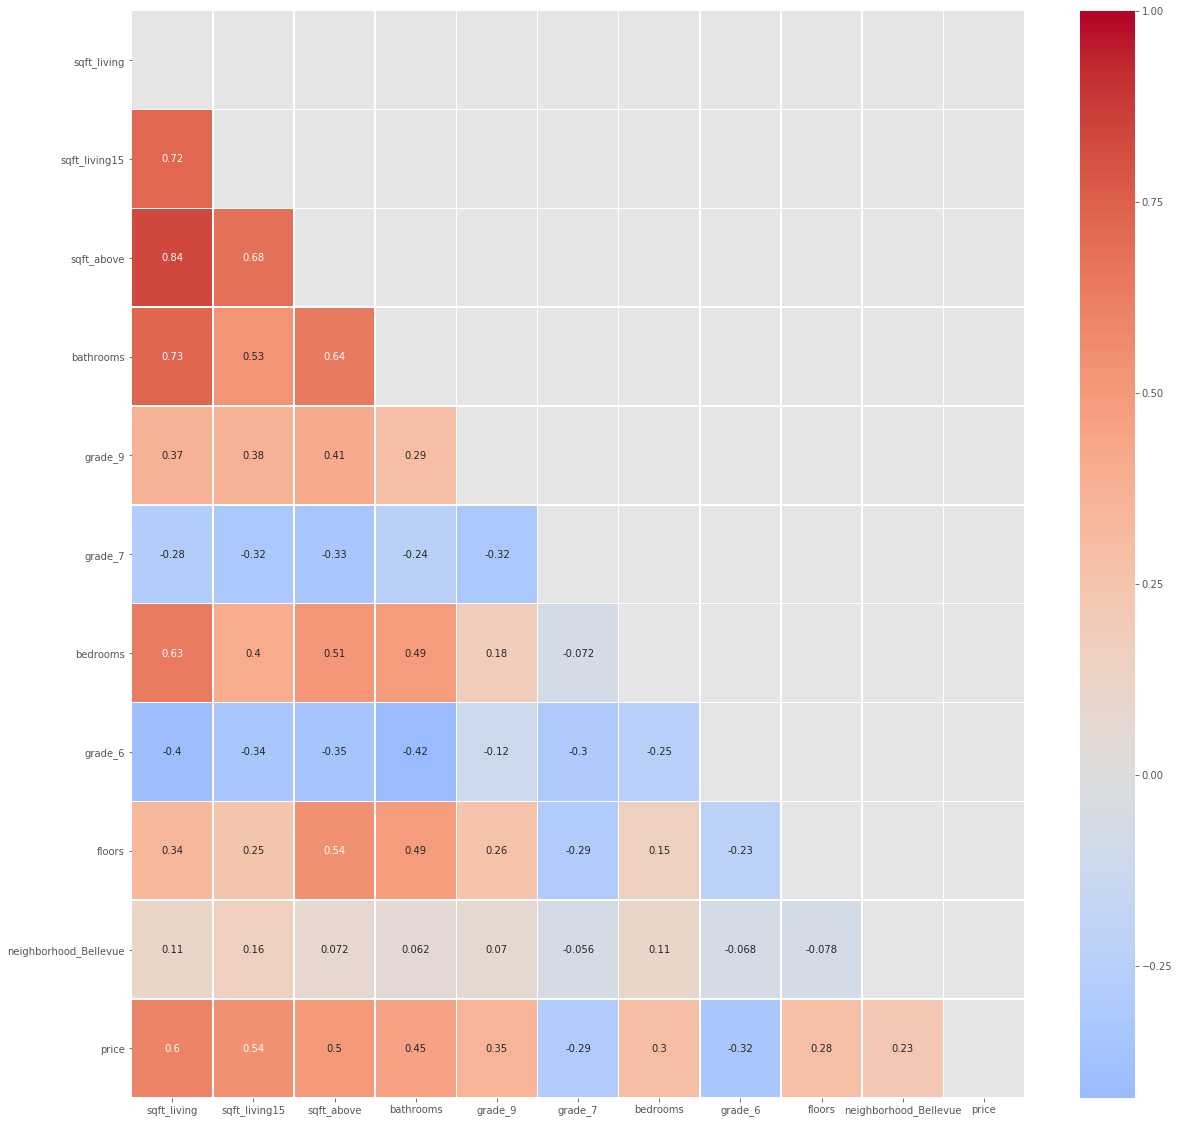

In [291]:
corr = normalized_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            linewidths=.5,annot=True);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

In [292]:
#test for variance inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [293]:
X = normalized_df[x_cols_4]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 2061.7028682103637),
 ('bathrooms', 1110.68671860317),
 ('sqft_living', 1687.9138280428238),
 ('sqft_lot', 9.08403321943736),
 ('floors', 1.3789226567522157),
 ('sqft_above', 2.685809329073194),
 ('sqft_basement', 25.9706152648695),
 ('sqft_living15', 1.7073980265072726),
 ('sqft_lot15', 16.00478506360813),
 ('home_age', 1.1137493320515528)]

In [294]:
corr[(corr.abs())>0.7]

,sqft_living,sqft_living15,sqft_above,bathrooms,grade_9,grade_7,bedrooms,grade_6,floors,neighborhood_Bellevue,price
sqft_living,1.000000,0.717936,0.837375,0.730078,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_living15,0.717936,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_above,0.837375,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,0.730078,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
grade_9,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
grade_7,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
bedrooms,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
grade_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
floors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
neighborhood_Bellevue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [295]:
#Seeing high correlation between sqft_living and many other variables
#Test model using sqft_living only, dropping sqft_living15 and sqft_above
#Also seeing high correlation with bathroom
#let's first test model with sqft features removed

## Model 5

In [296]:
sqft_living_df = normalized_df.copy()
sqft_living_df = sqft_living_df.drop(['sqft_living15', 'sqft_above'], axis=1)

In [297]:
outcome = 'price'
x_cols_5 = list(sqft_living_df.columns)
x_cols_5.remove('price')

predictors5 = '+'.join(x_cols_5)
formula5 = outcome + '~' + predictors5

model5 = ols(formula=formula5, data=sqft_living_df).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     1600.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:36:13   Log-Likelihood:                -5321.1
No. Observations:               15953   AIC:                         1.066e+04
Df Residuals:                   15944   BIC:                         1.073e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.6340      0.086    100.861      0.000       8.466       8.802
sqft_living               0.6100      0.012     49.286      0.000       0.586       0.634
bathrooms                -0.0688      0.012     -5.977      0.000      -0.091      -0.046
grade_9                   0.1326      0.009     14.024      0.000       0.114       0.151
grade_7                  -0.1539      0.007    -22.167      0.000      -0.168      -0.140
bedrooms                 -0.0535      0.004    -12.930      0.000      -0.062      -0.045
grade_6                  -0.2741      0.012    -23.446      0.000      -0.297      -0.251
floors                    0.0356      0.006      5.928      0.000       0.024       0.047
neighborhood_Bellevue     0.3197      0.012     27.194      0.000       0.297       0.343
==============================================================================
Omnibus:                       61.862   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.945
Skew:                          -0.021   Prob(JB):                     6.40e-11
Kurtosis:                       2.738   Cond. No.                         274.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [298]:
X_train5 = sqft_living_df.drop('price',axis=1)
y_train5 = sqft_living_df.price

X_test5 = X_test[x_cols_5]
y_test5 = y_test.copy()

linreg5 = LinearRegression() 
linreg5.fit(X_train5, y_train5)
y_hat_train5 = linreg5.predict(X_train5)
y_hat_test5 = linreg5.predict(X_test5)

train_mse5 = mean_squared_error(y_train5, y_hat_train5) 
test_mse5 = mean_squared_error(y_test5, y_hat_test5) 
print('Train Mean Squarred Error:', train_mse5) 
print('Test Mean Squarred Error:', test_mse5)

test_mse5-train_mse5

Train Mean Squarred Error: 0.11408839002265374
Test Mean Squarred Error: 277020869731.39215


277020869731.2781

In [ ]:
#This model is worse. Let's look for multicolinearity in our best df so far
#high_corr_df

## Checking for multicolinearity using high_corr_df

In [299]:
corr = high_corr_df.corr()
corr[(corr.abs())>0.7]

,sqft_living,sqft_living15,sqft_above,bathrooms,grade_9,grade_7,bedrooms,grade_6,floors,neighborhood_Bellevue,price
sqft_living,1.000000,0.734581,0.838618,0.705146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_living15,0.734581,1.000000,0.706569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_above,0.838618,0.706569,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,0.705146,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
grade_9,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
grade_7,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
bedrooms,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
grade_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
floors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
neighborhood_Bellevue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [302]:
sqft_living_2_df = high_corr_df.copy()
sqft_living_2_df = sqft_living_2_df.drop(['sqft_living15', 'sqft_above'], axis=1)

In [301]:
len(normalized_df.columns)

11

## Model 6

In [303]:
outcome = 'price'
x_cols_6 = list(sqft_living_2_df.columns)
x_cols_6.remove('price')

predictors6 = '+'.join(x_cols_6)
formula6 = outcome + '~' + predictors6

model6 = ols(formula=formula6, data=sqft_living_2_df).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     1675.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:41:36   Log-Likelihood:            -2.1389e+05
No. Observations:               15953   AIC:                         4.278e+05
Df Residuals:                   15944   BIC:                         4.279e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.907e+05   7620.263     38.148      0.000    2.76e+05    3.06e+05
sqft_living             159.4898      2.989     53.358      0.000     153.631     165.349
bathrooms             -1.264e+04   2963.030     -4.265      0.000   -1.84e+04   -6829.336
grade_9                6.968e+04   4541.348     15.343      0.000    6.08e+04    7.86e+04
grade_7               -7.021e+04   3348.456    -20.968      0.000   -7.68e+04   -6.36e+04
bedrooms              -2.572e+04   1935.319    -13.292      0.000   -2.95e+04   -2.19e+04
grade_6               -1.075e+05   5438.100    -19.774      0.000   -1.18e+05   -9.69e+04
floors                 9045.9726   2879.603      3.141      0.002    3401.626    1.47e+04
neighborhood_Bellevue  1.626e+05   5599.322     29.047      0.000    1.52e+05    1.74e+05
==============================================================================
Omnibus:                     1615.525   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2359.424
Skew:                           0.781   Prob(JB):                         0.00
Kurtosis:                       4.054   Cond. No.                     1.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [304]:
X_train6 = sqft_living_2_df.drop('price',axis=1)
y_train6 = sqft_living_2_df.price

X_test6 = X_test[x_cols_6]
y_test6 = y_test.copy()

linreg6 = LinearRegression() 
linreg6.fit(X_train6, y_train6)
y_hat_train6 = linreg6.predict(X_train6)
y_hat_test6 = linreg6.predict(X_test6)

train_mse6 = mean_squared_error(y_train6, y_hat_train6) 
test_mse6 = mean_squared_error(y_test6, y_hat_test6) 
print('Train Mean Squarred Error:', train_mse6) 
print('Test Mean Squarred Error:', test_mse6)

test_mse6-train_mse6

Train Mean Squarred Error: 25880849635.341957
Test Mean Squarred Error: 25894714124.073627


13864488.73167038

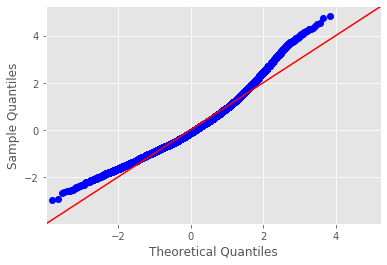

In [305]:
#Somewhat skewed distribution of residuals

plt.style.use('ggplot')

resid = model6.resid

fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

In [306]:
sqft_living_2_df.columns

Index(['sqft_living', 'bathrooms', 'grade_9', 'grade_7', 'bedrooms', 'grade_6',
       'floors', 'neighborhood_Bellevue', 'price'],
      dtype='object')

In [316]:
selective = sqft_living_2_df[['price','sqft_living','bedrooms','neighborhood_Bellevue']]

In [317]:
outcome = 'price'
x_cols_7 = list(selective.columns)
x_cols_7.remove('price')

predictors7 = '+'.join(x_cols_7)
formula7 = outcome + '~' + predictors7

model7 = ols(formula=formula7, data=selective).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     3854.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:54:53   Log-Likelihood:            -2.1440e+05
No. Observations:               15953   AIC:                         4.288e+05
Df Residuals:                   15949   BIC:                         4.288e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.916e+05   5304.049     36.129      0.000    1.81e+05    2.02e+05
sqft_living             204.0150      2.281     89.429      0.000     199.543     208.487
bedrooms              -3.613e+04   1941.080    -18.611      0.000   -3.99e+04   -3.23e+04
neighborhood_Bellevue  1.725e+05   5707.630     30.214      0.000    1.61e+05    1.84e+05
==============================================================================
Omnibus:                     1680.608   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2481.161
Skew:                           0.801   Prob(JB):                         0.00
Kurtosis:                       4.081   Cond. No.                     9.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [318]:
X_train7 = selective.drop('price',axis=1)
y_train7 = selective.price

X_test7 = X_test[x_cols_7]
y_test7 = y_test.copy()

linreg7 = LinearRegression() 
linreg7.fit(X_train7, y_train7)
y_hat_train7 = linreg7.predict(X_train7)
y_hat_test7 = linreg7.predict(X_test7)

train_mse7 = mean_squared_error(y_train7, y_hat_train7) 
test_mse7 = mean_squared_error(y_test7, y_hat_test7) 
print('Train Mean Squarred Error:', train_mse7) 
print('Test Mean Squarred Error:', test_mse7)

test_mse7-train_mse7

Train Mean Squarred Error: 27612793387.883266
Test Mean Squarred Error: 27796219690.79838


183426302.91511536

# Misc

In [360]:
last_df = train_df.copy()

In [361]:
df_corr_2 = last_df.corr().loc[['price']].abs().stack().reset_index().sort_values(0, ascending=False)
df_corr_2.set_index('level_1',inplace=True)
df_corr_2.drop('level_0',axis=1,inplace=True)
df_corr_2.drop('price',axis=0,inplace=True)
top_20_feats = list(df_corr_2[:20].index)

In [362]:
top_20_feats.append('price')

In [363]:
last_df = last_df[top_20_feats]

In [364]:
outcome = 'price'
x_cols_7 = list(last_df.columns)
x_cols_7.remove('price')

predictors7 = '+'.join(x_cols_7)
formula7 = outcome + '~' + predictors7

model7 = ols(formula=formula7, data=last_df).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     1145.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:06:21   Log-Likelihood:            -2.1189e+05
No. Observations:               15953   AIC:                         4.238e+05
Df Residuals:                   15933   BIC:                         4.240e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   3.041e+05   9530.343     31.912      0.000    2.85e+05    3.23e+05
sqft_living                   68.1170      2.391     28.488      0.000      63.430      72.804
sqft_living15                 32.4802      3.140     10.343      0.000      26.325      38.636
sqft_above                    42.0899      2.803     15.014      0.000      36.595      47.585
bathrooms                  -1.325e+04   2671.420     -4.960      0.000   -1.85e+04   -8013.372
grade_9                        8.6185   6216.007      0.001      0.999   -1.22e+04    1.22e+04
grade_7                    -1.286e+05   6109.473    -21.056      0.000   -1.41e+05   -1.17e+05
bedrooms                   -1.339e+04   1736.485     -7.711      0.000   -1.68e+04   -9986.706
grade_6                    -1.674e+05   7252.421    -23.086      0.000   -1.82e+05   -1.53e+05
floors                      3.005e+04   2950.237     10.185      0.000    2.43e+04    3.58e+04
sqft_basement                 26.0271      3.833      6.790      0.000      18.514      33.540
neighborhood_Bellevue       1.449e+05   5036.292     28.778      0.000    1.35e+05    1.55e+05
neighborhood_Kent           -1.62e+05   4820.067    -33.617      0.000   -1.71e+05   -1.53e+05
neighborhood_Mercer_Island  2.788e+05   1.16e+04     23.977      0.000    2.56e+05    3.02e+05
has_basement_1_0            6.695e+04   4500.869     14.874      0.000    5.81e+04    7.58e+04
neighborhood_Federal_Way    -1.87e+05   5863.692    -31.889      0.000   -1.98e+05   -1.75e+05
neighborhood_Sammamish      4.347e+04   6440.548      6.750      0.000    3.08e+04    5.61e+04
grade_11                    1.372e+05   1.73e+04      7.948      0.000    1.03e+05    1.71e+05
view_4_0                    2.281e+05   1.29e+04     17.745      0.000    2.03e+05    2.53e+05
grade_8                    -7.966e+04   5841.072    -13.639      0.000   -9.11e+04   -6.82e+04
view_2_0                    7.073e+04   5895.252     11.999      0.000    5.92e+04    8.23e+04
==============================================================================
Omnibus:                     1875.555   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3290.609
Skew:                           0.797   Prob(JB):                         0.00
Kurtosis:                       4.553   Cond. No.                     3.94e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.17e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [365]:
X_train7 = last_df.drop('price',axis=1)
y_train7 = last_df.price

X_test7 = X_test[x_cols_7]
y_test7 = y_test.copy()

linreg7 = LinearRegression() 
linreg7.fit(X_train7, y_train7)
y_hat_train7 = linreg7.predict(X_train7)
y_hat_test7 = linreg7.predict(X_test7)

train_mse7 = mean_squared_error(y_train7, y_hat_train7) 
test_mse7 = mean_squared_error(y_test7, y_hat_test7) 
print('Train Mean Squarred Error:', train_mse7) 
print('Test Mean Squarred Error:', test_mse7)

test_mse7-train_mse7

Train Mean Squarred Error: 20139147147.3633
Test Mean Squarred Error: 20714471877.149426


575324729.7861252

In [366]:
corr = last_df.corr()
corr[(corr.abs())>0.7]

,sqft_living,sqft_living15,sqft_above,bathrooms,grade_9,grade_7,bedrooms,grade_6,floors,sqft_basement,...,neighborhood_Kent,neighborhood_Mercer_Island,has_basement_1_0,neighborhood_Federal_Way,neighborhood_Sammamish,grade_11,view_4_0,grade_8,view_2_0,price
sqft_living,1.000000,0.734581,0.838618,0.705146,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_living15,0.734581,1.000000,0.706569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_above,0.838618,0.706569,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bathrooms,0.705146,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
grade_9,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
grade_7,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
grade_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
floors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_basement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,0.839841,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [367]:
last_df_2 = last_df.drop(['sqft_living15', 'sqft_above','floors'], axis=1)

In [368]:
outcome = 'price'
x_cols_7 = list(last_df_2.columns)
x_cols_7.remove('price')

predictors7 = '+'.join(x_cols_7)
formula7 = outcome + '~' + predictors7

model7 = ols(formula=formula7, data=last_df_2).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     1255.
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:06:21   Log-Likelihood:            -2.1198e+05
No. Observations:               15953   AIC:                         4.240e+05
Df Residuals:                   15935   BIC:                         4.241e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   3.686e+05   8262.360     44.614      0.000    3.52e+05    3.85e+05
sqft_living                  131.6468      3.048     43.192      0.000     125.673     137.621
bathrooms                  -4040.1400   2494.758     -1.619      0.105   -8930.147     849.867
grade_9                     3308.6651   6243.192      0.530      0.596   -8928.696    1.55e+04
grade_7                    -1.402e+05   6072.369    -23.083      0.000   -1.52e+05   -1.28e+05
bedrooms                   -1.517e+04   1741.097     -8.712      0.000   -1.86e+04   -1.18e+04
grade_6                    -1.831e+05   7187.570    -25.474      0.000   -1.97e+05   -1.69e+05
sqft_basement                -42.7348      5.946     -7.187      0.000     -54.390     -31.079
neighborhood_Bellevue       1.461e+05   4977.041     29.363      0.000    1.36e+05    1.56e+05
neighborhood_Kent          -1.635e+05   4836.707    -33.796      0.000   -1.73e+05   -1.54e+05
neighborhood_Mercer_Island  2.862e+05   1.16e+04     24.660      0.000    2.63e+05    3.09e+05
has_basement_1_0            6.899e+04   4523.525     15.251      0.000    6.01e+04    7.79e+04
neighborhood_Federal_Way   -1.912e+05   5867.234    -32.585      0.000   -2.03e+05    -1.8e+05
neighborhood_Sammamish      4.905e+04   6409.704      7.652      0.000    3.65e+04    6.16e+04
grade_11                    1.462e+05   1.73e+04      8.432      0.000    1.12e+05     1.8e+05
view_4_0                    2.381e+05   1.29e+04     18.472      0.000    2.13e+05    2.63e+05
grade_8                     -8.17e+04   5852.766    -13.960      0.000   -9.32e+04   -7.02e+04
view_2_0                    7.495e+04   5910.326     12.682      0.000    6.34e+04    8.65e+04
==============================================================================
Omnibus:                     1890.675   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3391.736
Skew:                           0.793   Prob(JB):                         0.00
Kurtosis:                       4.608   Cond. No.                     3.31e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [369]:
X_train7 = last_df_2.drop('price',axis=1)
y_train7 = last_df_2.price

X_test7 = X_test[x_cols_7]
y_test7 = y_test.copy()

linreg7 = LinearRegression() 
linreg7.fit(X_train7, y_train7)
y_hat_train7 = linreg7.predict(X_train7)
y_hat_test7 = linreg7.predict(X_test7)

train_mse7 = mean_squared_error(y_train7, y_hat_train7) 
test_mse7 = mean_squared_error(y_test7, y_hat_test7) 
print('Train Mean Squarred Error:', train_mse7) 
print('Test Mean Squarred Error:', test_mse7)

test_mse7-train_mse7

Train Mean Squarred Error: 20368238852.95574
Test Mean Squarred Error: 21038734357.9159


670495504.9601593

In [373]:
exp = train_df.drop(['sqft_lot', 'floors','bathrooms',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'home_age', 'yrs_since_reno', 'waterfront_1_0', 'view_1_0', 'view_2_0',
       'view_3_0', 'view_4_0', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'yr_sold_2015'],axis=1)

In [376]:
outcome = 'price'
x_cols_7 = list(exp.columns)
x_cols_7.remove('price')

predictors7 = '+'.join(x_cols_7)
formula7 = outcome + '~' + predictors7

model7 = ols(formula=formula7, data=exp).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     928.2
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:09:52   Log-Likelihood:            -2.0988e+05
No. Observations:               15953   AIC:                         4.198e+05
Df Residuals:                   15917   BIC:                         4.201e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   2.873e+05   1.02e+04     28.046      0.000    2.67e+05    3.07e+05
bedrooms                   -9819.5143   1539.645     -6.378      0.000   -1.28e+04   -6801.636
bathrooms                     95.8766   2207.851      0.043      0.965   -4231.762    4423.515
sqft_living                  119.4822      2.613     45.722      0.000     114.360     124.604
grade_11                    8.697e+04   1.54e+04      5.654      0.000    5.68e+04    1.17e+05
grade_3                     -1.11e+05   1.26e+05     -0.881      0.378   -3.58e+05    1.36e+05
grade_4                    -2.898e+05   2.78e+04    -10.406      0.000   -3.44e+05   -2.35e+05
grade_5                    -2.828e+05   1.19e+04    -23.791      0.000   -3.06e+05   -2.59e+05
grade_6                    -2.883e+05   7708.404    -37.399      0.000   -3.03e+05   -2.73e+05
grade_7                    -2.324e+05   6678.149    -34.800      0.000   -2.45e+05   -2.19e+05
grade_8                    -1.662e+05   6228.389    -26.678      0.000   -1.78e+05   -1.54e+05
grade_9                    -6.933e+04   6229.063    -11.129      0.000   -8.15e+04   -5.71e+04
neighborhood_Bellevue       3.207e+05   6438.082     49.814      0.000    3.08e+05    3.33e+05
neighborhood_Black_Diamond  9.327e+04   1.64e+04      5.684      0.000    6.11e+04    1.25e+05
neighborhood_Bothell        1.398e+05   1.11e+04     12.638      0.000    1.18e+05    1.62e+05
neighborhood_Carnation      1.114e+05    1.6e+04      6.957      0.000       8e+04    1.43e+05
neighborhood_Duvall         9.279e+04   1.15e+04      8.053      0.000    7.02e+04    1.15e+05
neighborhood_Enumclaw       3.325e+04   1.14e+04      2.914      0.004    1.09e+04    5.56e+04
neighborhood_Fall_City      1.631e+05   2.07e+04      7.896      0.000    1.23e+05    2.04e+05
neighborhood_Federal_Way   -1.317e+04   6988.670     -1.884      0.060   -2.69e+04     529.734
neighborhood_Issaquah       1.931e+05   7373.584     26.194      0.000    1.79e+05    2.08e+05
neighborhood_Kenmore        1.319e+05   9605.599     13.731      0.000    1.13e+05    1.51e+05
neighborhood_Kent           1.255e+04   6309.197      1.989      0.047     184.422    2.49e+04
neighborhood_Kirkland       2.534e+05   6708.001     37.776      0.000     2.4e+05    2.67e+05
neighborhood_Maple_Valley   3.528e+04   7830.515      4.506      0.000    1.99e+04    5.06e+04
neighborhood_Medina         7.187e+05   5.14e+04     13.985      0.000    6.18e+05    8.19e+05
neighborhood_Mercer_Island   4.55e+05   1.12e+04     40.493      0.000    4.33e+05    4.77e+05
neighborhood_North_Bend     1.053e+05   1.11e+04      9.454      0.000    8.35e+04    1.27e+05
neighborhood_Redmond        2.354e+05   6828.825     34.473      0.000    2.22e+05    2.49e+05
neighborhood_Renton         7.729e+04   600

In [379]:
import statsmodels.api as sm
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [385]:
predictors = train_df.drop('price',axis=1)

In [386]:
result = stepwise_selection(predictors, train_df['price'], verbose=True)
print('resulting features:')
print(result)

Add  grade_7                        with p-value 0.0


/Users/Miriam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  sqft_living15                  with p-value 0.0
Add  neighborhood_Seattle           with p-value 0.0
Add  sqft_living                    with p-value 0.0
Add  neighborhood_Bellevue          with p-value 3.96937e-294
Add  neighborhood_Kirkland          with p-value 3.94018e-176
Add  neighborhood_Mercer_Island     with p-value 6.09318e-182
Add  neighborhood_Redmond           with p-value 1.9668e-168
Add  grade_6                        with p-value 2.07733e-123
Add  home_age                       with p-value 1.9093e-162
Add  grade_8                        with p-value 7.49221e-142
Add  grade_5                        with p-value 3.32033e-157
Add  neighborhood_Issaquah          with p-value 5.08281e-97
Add  neighborhood_Sammamish         with p-value 1.16832e-117
Add  floors                         with p-value 4.3241e-72
Add  view_4_0                       with p-value 2.42716e-63
Add  neighborhood_Woodinville       with p-value 6.55534e-61
Add  condition_5                    with p

/Users/Miriam/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  sqft_lot15                     with p-value 1.70408e-11
Add  neighborhood_Black_Diamond     with p-value 5.19503e-09
Add  waterfront_1_0                 with p-value 8.81444e-09
Add  has_basement_1_0               with p-value 9.06294e-09
Add  sqft_basement                  with p-value 2.02181e-13
Add  sqft_above                     with p-value 4.22149e-75
Drop sqft_basement                  with p-value 0.111764
Add  neighborhood_Maple_Valley      with p-value 4.30493e-09
Add  sqft_lot                       with p-value 6.79771e-08
Add  condition_3                    with p-value 7.70582e-08
Add  grade_11                       with p-value 4.45888e-07
Add  yrs_since_reno                 with p-value 1.30501e-06
resulting features:
['grade_7', 'sqft_living15', 'neighborhood_Seattle', 'sqft_living', 'neighborhood_Bellevue', 'neighborhood_Kirkland', 'neighborhood_Mercer_Island', 'neighborhood_Redmond', 'grade_6', 'home_age', 'grade_8', 'grade_5', 'neighborhood_Issaquah', 'neighbor

In [389]:
result_cols = list(result)
result_cols.append('price')
train_df_2 = train_df[result_cols]

In [388]:
len(train_df.columns)

54

In [390]:
outcome = 'price'
x_cols_7 = list(train_df_2.columns)
x_cols_7.remove('price')

predictors7 = '+'.join(x_cols_7)
formula7 = outcome + '~' + predictors7

model7 = ols(formula=formula7, data=train_df_2).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     908.4
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:20:56   Log-Likelihood:            -2.0823e+05
No. Observations:               15953   AIC:                         4.166e+05
Df Residuals:                   15904   BIC:                         4.169e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   8.068e+04   1.57e+04      5.132      0.000    4.99e+04    1.11e+05
grade_7                    -2.349e+05   6289.467    -37.348      0.000   -2.47e+05   -2.23e+05
sqft_living15                 40.6514      2.643     15.383      0.000      35.471      45.831
neighborhood_Seattle        1.752e+05   3459.903     50.637      0.000    1.68e+05    1.82e+05
sqft_living                   50.6550      4.650     10.894      0.000      41.541      59.769
neighborhood_Bellevue       2.797e+05   4789.370     58.410      0.000     2.7e+05    2.89e+05
neighborhood_Kirkland       2.331e+05   5008.073     46.538      0.000    2.23e+05    2.43e+05
neighborhood_Mercer_Island  3.922e+05   9673.658     40.541      0.000    3.73e+05    4.11e+05
neighborhood_Redmond        2.344e+05   5151.011     45.503      0.000    2.24e+05    2.44e+05
grade_6                    -3.071e+05   7348.964    -41.785      0.000   -3.21e+05   -2.93e+05
home_age                    1786.7756     50.172     35.613      0.000    1688.432    1885.119
grade_8                    -1.668e+05   5733.125    -29.086      0.000   -1.78e+05   -1.56e+05
grade_5                    -3.277e+05   1.11e+04    -29.478      0.000    -3.5e+05   -3.06e+05
neighborhood_Issaquah       1.832e+05   5733.904     31.958      0.000    1.72e+05    1.94e+05
neighborhood_Sammamish       1.87e+05   5753.273     32.505      0.000    1.76e+05    1.98e+05
floors                      3.638e+04   2534.881     14.353      0.000    3.14e+04    4.14e+04
view_4_0                    1.628e+05   1.16e+04     13.995      0.000     1.4e+05    1.86e+05
neighborhood_Woodinville    1.645e+05   7011.339     23.459      0.000    1.51e+05    1.78e+05
condition_5                 1.126e+05   1.03e+04     10.968      0.000    9.24e+04    1.33e+05
neighborhood_Federal_Way   -2.277e+04   5305.428     -4.292      0.000   -3.32e+04   -1.24e+04
neighborhood_Medina          6.52e+05   4.63e+04     14.087      0.000    5.61e+05    7.43e+05
grade_9                    -6.995e+04   5635.026    -12.413      0.000    -8.1e+04   -5.89e+04
grade_4                    -3.357e+05   2.53e+04    -13.247      0.000   -3.85e+05   -2.86e+05
bathrooms                   2.513e+04   2293.332     10.957      0.000    2.06e+04    2.96e+04
bedrooms                   -1.166e+04   1402.562     -8.311      0.000   -1.44e+04   -8906.869
yr_sold_2015                2.131e+04   1918.113     11.108      0.000    1.75e+04    2.51e+04
view_3_0                    6.994e+04   7096.416      9.855      0.000     5.6e+04    8.38e+04
view_2_0                     4.47e+04   4762.697      9.385      0.000    3.54e+04     5.4e+04
neighborhood_Snoqualmie     1.182e+05   8263.453     14.299      0.000    1.02e+05    1.34e+05
neighborhood_Kenmore        1.144e+05   797

In [391]:
X_train7 = train_df_2.drop('price',axis=1)
y_train7 = train_df_2.price

X_test7 = X_test[x_cols_7]
y_test7 = y_test.copy()

linreg7 = LinearRegression() 
linreg7.fit(X_train7, y_train7)
y_hat_train7 = linreg7.predict(X_train7)
y_hat_test7 = linreg7.predict(X_test7)

train_mse7 = mean_squared_error(y_train7, y_hat_train7) 
test_mse7 = mean_squared_error(y_test7, y_hat_test7) 
print('Train Mean Squarred Error:', train_mse7) 
print('Test Mean Squarred Error:', test_mse7)

test_mse7-train_mse7

Train Mean Squarred Error: 12729049020.646154
Test Mean Squarred Error: 13068091115.602516


339042094.9563618

In [397]:
train_df_2.corr()[train_df_2.corr().abs()>0.7]

,grade_7,sqft_living15,neighborhood_Seattle,sqft_living,neighborhood_Bellevue,neighborhood_Kirkland,neighborhood_Mercer_Island,neighborhood_Redmond,grade_6,home_age,...,neighborhood_Black_Diamond,waterfront_1_0,has_basement_1_0,sqft_above,neighborhood_Maple_Valley,sqft_lot,condition_3,grade_11,yrs_since_reno,price
grade_7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_living15,NaN,1.000000,NaN,0.734581,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.706569,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_Seattle,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sqft_living,NaN,0.734581,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.838618,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_Bellevue,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_Kirkland,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_Mercer_Island,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_Redmond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
grade_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
home_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [401]:
list(train_df_2.columns)

['grade_7',
 'sqft_living15',
 'neighborhood_Seattle',
 'sqft_living',
 'neighborhood_Bellevue',
 'neighborhood_Kirkland',
 'neighborhood_Mercer_Island',
 'neighborhood_Redmond',
 'grade_6',
 'home_age',
 'grade_8',
 'grade_5',
 'neighborhood_Issaquah',
 'neighborhood_Sammamish',
 'floors',
 'view_4_0',
 'neighborhood_Woodinville',
 'condition_5',
 'neighborhood_Federal_Way',
 'neighborhood_Medina',
 'grade_9',
 'grade_4',
 'bathrooms',
 'bedrooms',
 'yr_sold_2015',
 'view_3_0',
 'view_2_0',
 'neighborhood_Snoqualmie',
 'neighborhood_Kenmore',
 'neighborhood_Bothell',
 'condition_4',
 'view_1_0',
 'neighborhood_North_Bend',
 'neighborhood_Renton',
 'neighborhood_Duvall',
 'neighborhood_Fall_City',
 'neighborhood_Carnation',
 'neighborhood_Vashon',
 'sqft_lot15',
 'neighborhood_Black_Diamond',
 'waterfront_1_0',
 'has_basement_1_0',
 'sqft_above',
 'neighborhood_Maple_Valley',
 'sqft_lot',
 'condition_3',
 'grade_11',
 'yrs_since_reno',
 'price']

In [405]:
train_df_3 = train_df_2.drop(['sqft_living15', 'sqft_lot15','sqft_above','sqft_lot','neighborhood_North_Bend',
 'neighborhood_Renton',
 'neighborhood_Duvall',
 'neighborhood_Fall_City',
 'neighborhood_Carnation',
 'neighborhood_Vashon','neighborhood_Bellevue',
 'neighborhood_Kirkland',
 'neighborhood_Mercer_Island',
 'neighborhood_Redmond','neighborhood_Issaquah',
 'neighborhood_Sammamish','neighborhood_Black_Diamond',
 'neighborhood_Snoqualmie',
 'neighborhood_Kenmore',
 'neighborhood_Bothell','neighborhood_Maple_Valley'],axis=1)

In [406]:
outcome = 'price'
x_cols_7 = list(train_df_3.columns)
x_cols_7.remove('price')

predictors7 = '+'.join(x_cols_7)
formula7 = outcome + '~' + predictors7

model7 = ols(formula=formula7, data=train_df_3).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     942.1
Date:                Sat, 24 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:32:06   Log-Likelihood:            -2.1114e+05
No. Observations:               15953   AIC:                         4.223e+05
Df Residuals:                   15925   BIC:                         4.225e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 3.478e+05   1.76e+04     19.719      0.000    3.13e+05    3.82e+05
grade_7                  -3.432e+05   7113.178    -48.245      0.000   -3.57e+05   -3.29e+05
neighborhood_Seattle      3.036e+04   2836.519     10.702      0.000    2.48e+04    3.59e+04
sqft_living                 91.9992      2.857     32.197      0.000      86.398      97.600
grade_6                  -4.363e+05   8313.510    -52.483      0.000   -4.53e+05    -4.2e+05
home_age                  2277.7551     59.427     38.329      0.000    2161.272    2394.238
grade_8                  -2.386e+05   6626.279    -36.004      0.000   -2.52e+05   -2.26e+05
grade_5                  -4.831e+05   1.29e+04    -37.449      0.000   -5.08e+05   -4.58e+05
floors                    3.079e+04   2856.868     10.776      0.000    2.52e+04    3.64e+04
view_4_0                  1.701e+05   1.39e+04     12.275      0.000    1.43e+05    1.97e+05
neighborhood_Woodinville  1.703e+04   7573.051      2.249      0.025    2185.112    3.19e+04
condition_5               8.763e+04   1.23e+04      7.146      0.000    6.36e+04    1.12e+05
neighborhood_Federal_Way -1.583e+05   5670.690    -27.920      0.000   -1.69e+05   -1.47e+05
neighborhood_Medina       5.077e+05   5.54e+04      9.164      0.000    3.99e+05    6.16e+05
grade_9                  -1.035e+05   6682.689    -15.491      0.000   -1.17e+05   -9.04e+04
grade_4                   -4.73e+05   3.01e+04    -15.698      0.000   -5.32e+05   -4.14e+05
bathrooms                 2.697e+04   2743.369      9.831      0.000    2.16e+04    3.23e+04
bedrooms                 -1.336e+04   1669.883     -7.998      0.000   -1.66e+04   -1.01e+04
yr_sold_2015              1.624e+04   2298.052      7.065      0.000    1.17e+04    2.07e+04
view_3_0                  6.504e+04   8420.228      7.725      0.000    4.85e+04    8.15e+04
view_2_0                  4.714e+04   5658.401      8.331      0.000     3.6e+04    5.82e+04
condition_4               6.209e+04   1.18e+04      5.260      0.000     3.9e+04    8.52e+04
view_1_0                  8.026e+04   9125.069      8.795      0.000    6.24e+04    9.81e+04
waterfront_1_0            9.656e+04   2.37e+04      4.067      0.000       5e+04    1.43e+05
has_basement_1_0           2.36e+04   2713.382      8.698      0.000    1.83e+04    2.89e+04
condition_3               4.038e+04   1.17e+04      3.437      0.001    1.74e+04    6.34e+04
grade_11                  8.958e+04   1.66e+04      5.390      0.000     5.7e+04    1.22e+05
yrs_since_reno              -5.7643      3.252     -1.772      0.076     -12.139       0.611
==============================================================================
Omnibus:                     1240.083   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Ja